In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from textwrap import wrap
from textblob import TextBlob

from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from scipy.cluster.hierarchy import dendrogram

import re
import string
import time
from PIL import Image
from collections import Counter

import plotly.express as px

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words as nltk_words
from nltk.corpus import stopwords

nltk.download('stopwords', download_dir='./resources')
nltk.download('punkt', download_dir='./resources')
nltk.download('wordnet', download_dir='./resources')
nltk.download('omw-1.4', download_dir='./resources')
nltk.download('words', download_dir='./resources')
nltk.data.path.append('./resources')

[nltk_data] Downloading package stopwords to ./resources...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to ./resources...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to ./resources...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to ./resources...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to ./resources...
[nltk_data]   Package words is already up-to-date!


# TODO:
* apply models
* compare with google trends **[DONE]**
* change wordcloud colors **[DONE]**
* apply all to descriptions
* run wss for KMeans

## Trends limits:
By default, it is set to 100 requests per 100 seconds per user and can be adjusted to a maximum value of 1,000. But the number of requests to the API is restricted to a maximum of 10 requests per second per user.

In [2]:
!ls && ls ./Data

Data                        infer_results.ipynb
assets                      resources
descriptions_analysis.ipynb titles_analysis.ipynb
bbc_news.csv                          description-kmeans-clusters.csv
clusters.csv                          description-optics-clusters.csv
description-agg-complete-clusters.csv kmeans-clusters.csv
description-agg-ward-clusters.csv     topics_short.csv
description-dbscan-clusters.csv


### Configs...

In [3]:
TRENDS = True

# Exploratory Data Analysis

In [4]:
data = pd.read_csv('Data/bbc_news.csv')
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
8116  What time is the Queen's funeral? Who will wea...   
8117  Queen's funeral guests: Who will - and who won...   
8118    The cowboy and the Queen who bonded over horses   
8119   Queen amused by an American's breach of protocol   
8120  Queen Elizabeth II's special connection with W...   

                            pubDate  \
0     Mon, 07 Mar 2022 08:01:56 GMT   
1     Sun, 06 Mar 2022 22:49:58 GMT   
2     Mon, 07 Mar 2022 00:14:42 GMT   
3     Mon, 07 Mar 2022 00:05:40 GMT   
4     Mon, 07 Mar 2022 08:15:53 GMT   
...                             ...   
8116  Sat, 17 Sep 2022 22:54:46 GMT   
8117  Sat, 17 Sep 2022 06:25:17 GMT   
8118  Fri, 16 Sep 2022 23:01:06 GMT   
8119  Fri, 16 Sep 2022 14:52:59 GMT   
8120  Sat, 17 Sep 2022 06:38:22 GMT   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
8116             https://www.bbc.co.uk/news/uk-62844663   
8117             https://www.bbc.co.uk/news/uk-62890879   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
8116  https://www.bbc.co.uk/news/uk-62844663?at_medi...   
8117  https://www.bbc.co.uk/news/uk-62890879?at_medi...   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
8116  The death of Queen Elizabeth II has had a majo...  
8117  Here's what we know so far about who will and ...  
8118  Sitting with the heads of state at Monday's fu...  
8119  When the monarch visited a US housing project ...  
8120  The Queen's association with Windsor Great Par...  

[8121 rows x 5 columns]

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8121 entries, 0 to 8120
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        8121 non-null   object
 1   pubDate      8121 non-null   object
 2   guid         8121 non-null   object
 3   link         8121 non-null   object
 4   description  8121 non-null   object
dtypes: object(5)
memory usage: 317.4+ KB


In [6]:
data.describe()

title  \
count                                                8121   
unique                                               7746   
top     Ukraine war in maps: Tracking the Russian inva...   
freq                                                   32   

                              pubDate  \
count                            8121   
unique                           7981   
top     Fri, 15 Jul 2022 15:23:03 GMT   
freq                                3   

                                                    guid  \
count                                               8121   
unique                                              7432   
top     https://www.bbc.co.uk/news/world-europe-60506682   
freq                                                  40   

                                                     link  \
count                                                8121   
unique                                               7432   
top     https://www.bbc.co.uk/news/world-europe-605066...   
freq                                                   40   

                                              description  
count                                                8121  
unique                                               7645  
top     How closely have you been paying attention to ...  
freq                                                   23

In [6]:
data['pubDate'] = pd.to_datetime(data['pubDate'], infer_datetime_format=True)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
8116  What time is the Queen's funeral? Who will wea...   
8117  Queen's funeral guests: Who will - and who won...   
8118    The cowboy and the Queen who bonded over horses   
8119   Queen amused by an American's breach of protocol   
8120  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
8116 2022-09-17 22:54:46+00:00   
8117 2022-09-17 06:25:17+00:00   
8118 2022-09-16 23:01:06+00:00   
8119 2022-09-16 14:52:59+00:00   
8120 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
8116             https://www.bbc.co.uk/news/uk-62844663   
8117             https://www.bbc.co.uk/news/uk-62890879   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
8116  https://www.bbc.co.uk/news/uk-62844663?at_medi...   
8117  https://www.bbc.co.uk/news/uk-62890879?at_medi...   
8118  https://www.bbc.co.uk/news/world-us-canada-629...   
8119  https://www.bbc.co.uk/news/world-us-canada-629...   
8120  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
8116  The death of Queen Elizabeth II has had a majo...  
8117  Here's what we know so far about who will and ...  
8118  Sitting with the heads of state at Monday's fu...  
8119  When the monarch visited a US housing project ...  
8120  The Queen's association with Windsor Great Par...  

[8121 rows x 5 columns]

## Remove duplicates

In [7]:
data = data.drop_duplicates(subset=['title']).drop_duplicates(subset=['guid']).drop_duplicates(subset=['description']).reset_index(drop=True)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  
0     The Ukrainian president says the country will ...  
1     Jeremy Bowen was on the frontline in Irpin, as...  
2     One of the world's biggest fertiliser firms sa...  
3     The parents of the Manchester Arena bombing's ...  
4     Consumers are feeling the impact of higher ene...  
...                                                 ...  
7359  Saracens battle back from 17-0 down to beat Ha...  
7360  Thousands of people have lined up for miles to...  
7361  Sitting with the heads of state at Monday's fu...  
7362  When the monarch visited a US housing project ...  
7363  The Queen's association with Windsor Great Par...  

[7364 rows x 5 columns]

In [8]:
data['title'].str.split(expand=True).stack().value_counts()

to               1807
in               1428
of               1104
and               987
the               893
                 ... 
'confident'         1
impasse             1
'apocalyptic'       1
Wheeler             1
American's          1
Length: 17015, dtype: int64

In [9]:
STOPWORDS = stopwords.words('english')
pd.Series(STOPWORDS)

0             i
1            me
2            my
3        myself
4            we
         ...   
174     weren't
175         won
176       won't
177      wouldn
178    wouldn't
Length: 179, dtype: object

## Remove stopwords and count frequencies for single words

In [10]:
sns.set_style('darkgrid')

In [11]:
top_N = 50
a = data['title'].str.lower().str.replace(r'[^\w\s]', '', regex=True).str.cat(sep=' ')
words = list(filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(a)))
word_dist = nltk.FreqDist(words)
freq_title = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
freq_title

Word  Frequency
0        ukraine        728
1            war        503
2        england        352
3           2022        336
4           says        333
5            new        274
6             uk        264
7          world        201
8             us        201
9            win        195
10             v        176
11       russian        174
12         first        161
13        papers        157
14        russia        156
15           man        155
16          city        145
17         queen        136
18        league        133
19         covid        124
20          open        123
21           day        122
22         final        122
23           cup        119
24          euro        117
25         games        114
26        energy        108
27         could        107
28  commonwealth        105
29            pm        104
30      election        100
31         years         98
32     liverpool         93
33    manchester         91
34       johnson         91
35          cost         91
36          back         87
37        living         86
38         boris         85
39        police         84
40        womens         84
41          wins         84
42          life         83
43     wimbledon         81
44          tory         79
45       roundup         78
46         south         76
47       chelsea         75
48           one         74
49      children         73

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, 'ukraine'),
  Text(1, 0, 'war'),
  Text(2, 0, 'england'),
  Text(3, 0, '2022'),
  Text(4, 0, 'says'),
  Text(5, 0, 'new'),
  Text(6, 0, 'uk'),
  Text(7, 0, 'world'),
  Text(8, 0, 'us'),
  Text(9, 0, 'win'),
  Text(10, 0, 'v'),
  Text(11, 0, 'russian'),
  Text(12, 0, 'first'),
  Text(13, 0, 'papers'),
  Text(14, 0, 'russia'),
  Text(15, 0, 'man'),
  Text(16, 0, 'city'),
  Text(17, 0, 'queen'),
  Text(18, 0, 'league'),
  Text(19, 0, 'covid'),
  Text(20, 0, 'open'),
  Text(21, 0, 'day'),
  Text(22, 0, 'final'),
  Text(23, 0, 'cup'),
  Text(24, 0, 'euro'),
  Text(25, 0, 'games'),
  Text(26, 0, 'energy'),
  Text(27, 0, 'could'),
  Text(28, 0, 'commonwealth'),
  Text(29, 0, 'pm'),
  Text(30, 0, 'election'),
  Text(31, 0, 'years'),
  Text(32, 0, 'liverpool')

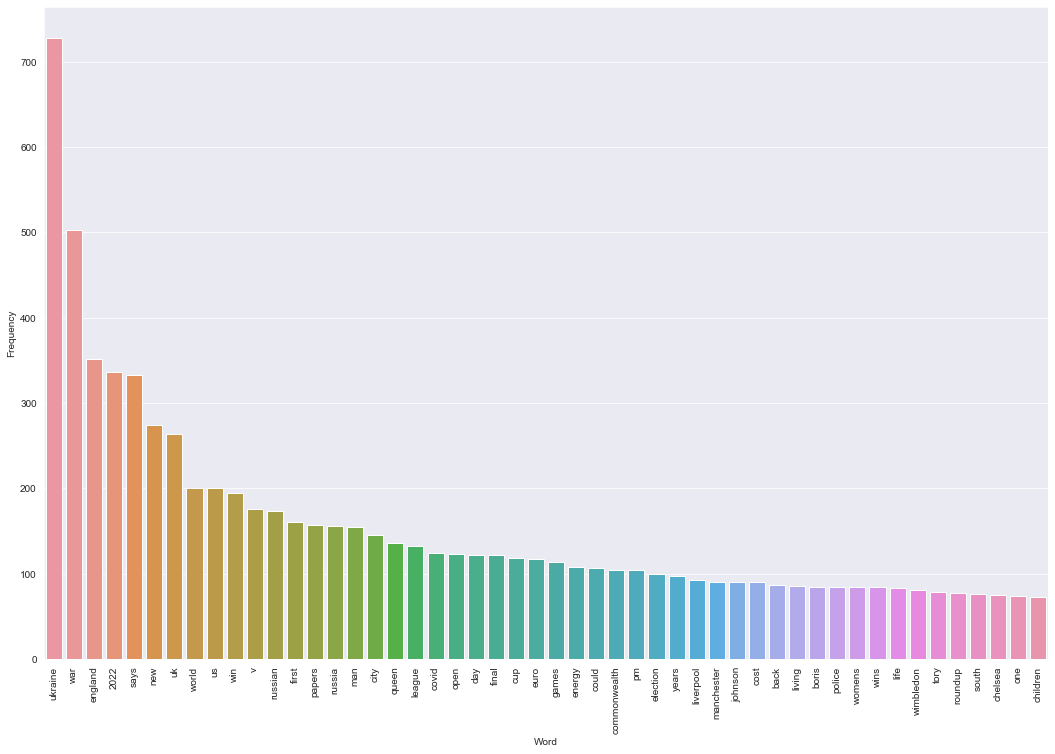

In [12]:
plt.figure(figsize=(18, 12))
sns.barplot(data=freq_title, x='Word', y='Frequency')
plt.xticks(rotation=90)

## Looking for the most popular 2-grams and 3-grams

In [13]:
def find_ngrams(input_list, n):
    return list(zip(*(input_list[i:] for i in range(n))))

In [14]:
bigrams = find_ngrams(words, 2)
bigrams

[('ukraine', 'angry'),
 ('angry', 'zelensky'),
 ('zelensky', 'vows'),
 ('vows', 'punish'),
 ('punish', 'russian'),
 ('russian', 'atrocities'),
 ('atrocities', 'war'),
 ('war', 'ukraine'),
 ('ukraine', 'taking'),
 ('taking', 'cover'),
 ('cover', 'town'),
 ('town', 'attack'),
 ('attack', 'ukraine'),
 ('ukraine', 'war'),
 ('war', 'catastrophic'),
 ('catastrophic', 'global'),
 ('global', 'food'),
 ('food', 'manchester'),
 ('manchester', 'arena'),
 ('arena', 'bombing'),
 ('bombing', 'saffie'),
 ('saffie', 'roussoss'),
 ('roussoss', 'parents'),
 ('parents', 'hearing'),
 ('hearing', 'truth'),
 ('truth', 'ukraine'),
 ('ukraine', 'conflict'),
 ('conflict', 'oil'),
 ('oil', 'price'),
 ('price', 'soars'),
 ('soars', 'highest'),
 ('highest', 'level'),
 ('level', 'since'),
 ('since', '2008'),
 ('2008', 'ukraine'),
 ('ukraine', 'war'),
 ('war', 'pm'),
 ('pm', 'hold'),
 ('hold', 'talks'),
 ('talks', 'world'),
 ('world', 'leaders'),
 ('leaders', 'sanctions'),
 ('sanctions', 'ukraine'),
 ('ukraine', 'w

In [15]:
bigrams_dist = nltk.FreqDist(bigrams)
bigram_freq_title = pd.DataFrame(bigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
bigram_freq_title

N-gram  Frequency
0              (ukraine, war)        340
1                (euro, 2022)        112
2                (england, v)         96
3       (commonwealth, games)         92
4                (world, cup)         73
5            (boris, johnson)         67
6              (cost, living)         67
7              (war, ukraine)         65
8             (south, africa)         57
9          (ukraine, roundup)         56
10               (liz, truss)         50
11        (platinum, jubilee)         46
12             (new, zealand)         45
13        (champions, league)         45
14         (queen, elizabeth)         43
15         (tory, leadership)         42
16          (premier, league)         40
17                (man, city)         39
18                 (v, south)         37
19            (elizabeth, ii)         36
20                 (us, open)         35
21          (climate, change)         34
22         (manchester, city)         34
23            (energy, bills)         33
24       (manchester, united)         32
25              (grand, prix)         32
26             (rishi, sunak)         31
27           (emma, raducanu)         31
28     (newspaper, headlines)         29
29               (sri, lanka)         29
30                   (v, new)         29
31        (northern, ireland)         27
32             (french, open)         26
33                 (man, utd)         25
34                (new, york)         25
35        (ukraine, conflict)         23
36           (world, snooker)         23
37    (snooker, championship)         23
38          (wimbledon, 2022)         23
39             (real, madrid)         22
40               (dies, aged)         21
41              (ros, atkins)         21
42             (andy, murray)         21
43                 (v, india)         21
44                (west, ham)         20
45                  (fa, cup)         20
46          (elections, 2022)         20
47           (election, 2022)         20
48  (european, championships)         20
49              (ben, stokes)         20

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('ukraine', 'war')"),
  Text(1, 0, "('euro', '2022')"),
  Text(2, 0, "('england', 'v')"),
  Text(3, 0, "('commonwealth', 'games')"),
  Text(4, 0, "('world', 'cup')"),
  Text(5, 0, "('boris', 'johnson')"),
  Text(6, 0, "('cost', 'living')"),
  Text(7, 0, "('war', 'ukraine')"),
  Text(8, 0, "('south', 'africa')"),
  Text(9, 0, "('ukraine', 'roundup')"),
  Text(10, 0, "('liz', 'truss')"),
  Text(11, 0, "('platinum', 'jubilee')"),
  Text(12, 0, "('new', 'zealand')"),
  Text(13, 0, "('champions', 'league')"),
  Text(14, 0, "('queen', 'elizabeth')"),
  Text(15, 0, "('tory', 'leadership')"),
  Text(16, 0, "('premier', 'league')"),
  Text(17, 0, "('man', 'city')"),
  Text(18, 0, "('v', 'south')"),
  Text(19, 0, "('elizabeth', 'ii')"),
  Text(20, 0, "('us', '

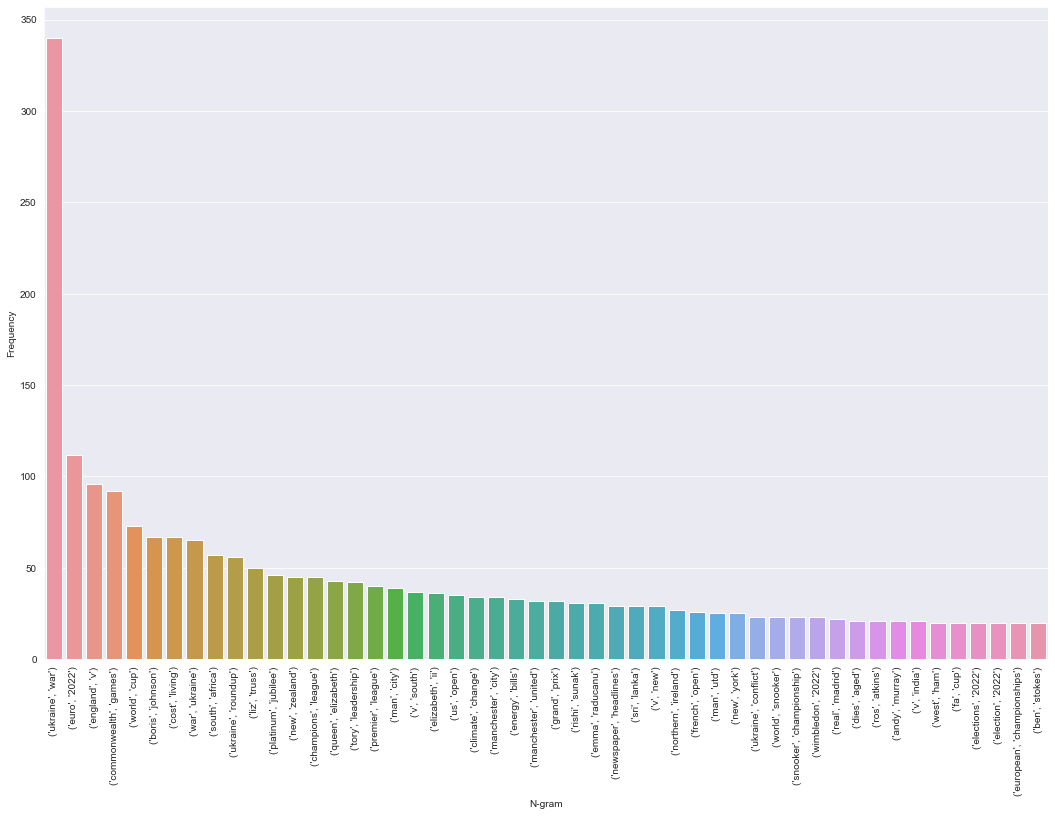

In [16]:
plt.figure(figsize=(18, 12))
sns.barplot(data=bigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

In [17]:
trigrams = find_ngrams(words, 3)
trigrams

[('ukraine', 'angry', 'zelensky'),
 ('angry', 'zelensky', 'vows'),
 ('zelensky', 'vows', 'punish'),
 ('vows', 'punish', 'russian'),
 ('punish', 'russian', 'atrocities'),
 ('russian', 'atrocities', 'war'),
 ('atrocities', 'war', 'ukraine'),
 ('war', 'ukraine', 'taking'),
 ('ukraine', 'taking', 'cover'),
 ('taking', 'cover', 'town'),
 ('cover', 'town', 'attack'),
 ('town', 'attack', 'ukraine'),
 ('attack', 'ukraine', 'war'),
 ('ukraine', 'war', 'catastrophic'),
 ('war', 'catastrophic', 'global'),
 ('catastrophic', 'global', 'food'),
 ('global', 'food', 'manchester'),
 ('food', 'manchester', 'arena'),
 ('manchester', 'arena', 'bombing'),
 ('arena', 'bombing', 'saffie'),
 ('bombing', 'saffie', 'roussoss'),
 ('saffie', 'roussoss', 'parents'),
 ('roussoss', 'parents', 'hearing'),
 ('parents', 'hearing', 'truth'),
 ('hearing', 'truth', 'ukraine'),
 ('truth', 'ukraine', 'conflict'),
 ('ukraine', 'conflict', 'oil'),
 ('conflict', 'oil', 'price'),
 ('oil', 'price', 'soars'),
 ('price', 'soars', 

In [18]:
trigrams_dist = nltk.FreqDist(trigrams)
trigram_freq_title = pd.DataFrame(trigrams_dist.most_common(top_N),
                    columns=['N-gram', 'Frequency'])
trigram_freq_title

N-gram  Frequency
0                  (v, south, africa)         37
1                 (england, v, south)         36
2              (queen, elizabeth, ii)         35
3                   (england, v, new)         29
4                   (v, new, zealand)         29
5      (world, snooker, championship)         23
6                 (england, v, india)         21
7              (ukraine, war, russia)         18
8         (commonwealth, games, 2022)         18
9                (womens, world, cup)         17
10                     (roe, v, wade)         17
11            (ukraine, war, russian)         16
12              (euro, 2022, england)         16
13      (snooker, championship, 2022)         14
14         (champions, league, final)         14
15          (election, results, 2022)         14
16                 (world, cup, 2022)         11
17             (cost, living, crisis)         11
18               (ni, election, 2022)         11
19  (world, athletics, championships)         11
20                (euro, 2022, final)         10
21             (womens, six, nations)          9
22    (commonwealth, games, englands)          9
23                 (ukraine, war, uk)          8
24              (garth, crooks, team)          8
25               (crooks, team, week)          8
26                 (grand, prix, max)          8
27            (prix, max, verstappen)          8
28             (open, emma, raducanu)          8
29      (northern, ireland, protocol)          8
30                   (fa, cup, final)          8
31         (platinum, jubilee, queen)          8
32                 (tour, de, france)          8
33               (south, africa, ben)          8
34              (africa, ben, stokes)          8
35        (gold, commonwealth, games)          8
36     (commonwealth, games, england)          8
37            (ukraine, war, ukraine)          7
38            (ukraine, ukraine, war)          7
39           (ukraine, war, zelensky)          7
40              (ukraine, war, putin)          7
41               (fa, cup, semifinal)          7
42               (energy, price, cap)          7
43                   (erik, ten, hag)          7
44             (rwanda, asylum, plan)          7
45                (sue, gray, report)          7
46               (us, supreme, court)          7
47            (us, pga, championship)          7
48            (ukraine, war, roundup)          7
49              (open, rafael, nadal)          7

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, "('v', 'south', 'africa')"),
  Text(1, 0, "('england', 'v', 'south')"),
  Text(2, 0, "('queen', 'elizabeth', 'ii')"),
  Text(3, 0, "('england', 'v', 'new')"),
  Text(4, 0, "('v', 'new', 'zealand')"),
  Text(5, 0, "('world', 'snooker', 'championship')"),
  Text(6, 0, "('england', 'v', 'india')"),
  Text(7, 0, "('ukraine', 'war', 'russia')"),
  Text(8, 0, "('commonwealth', 'games', '2022')"),
  Text(9, 0, "('womens', 'world', 'cup')"),
  Text(10, 0, "('roe', 'v', 'wade')"),
  Text(11, 0, "('ukraine', 'war', 'russian')"),
  Text(12, 0, "('euro', '2022', 'england')"),
  Text(13, 0, "('snooker', 'championship', '2022')"),
  Text(14, 0, "('champions', 'league', 'final')"),
  Text(15, 0, "('election', 'results', '2022')"),
  Text(16, 0, "('world', 'cup', '20

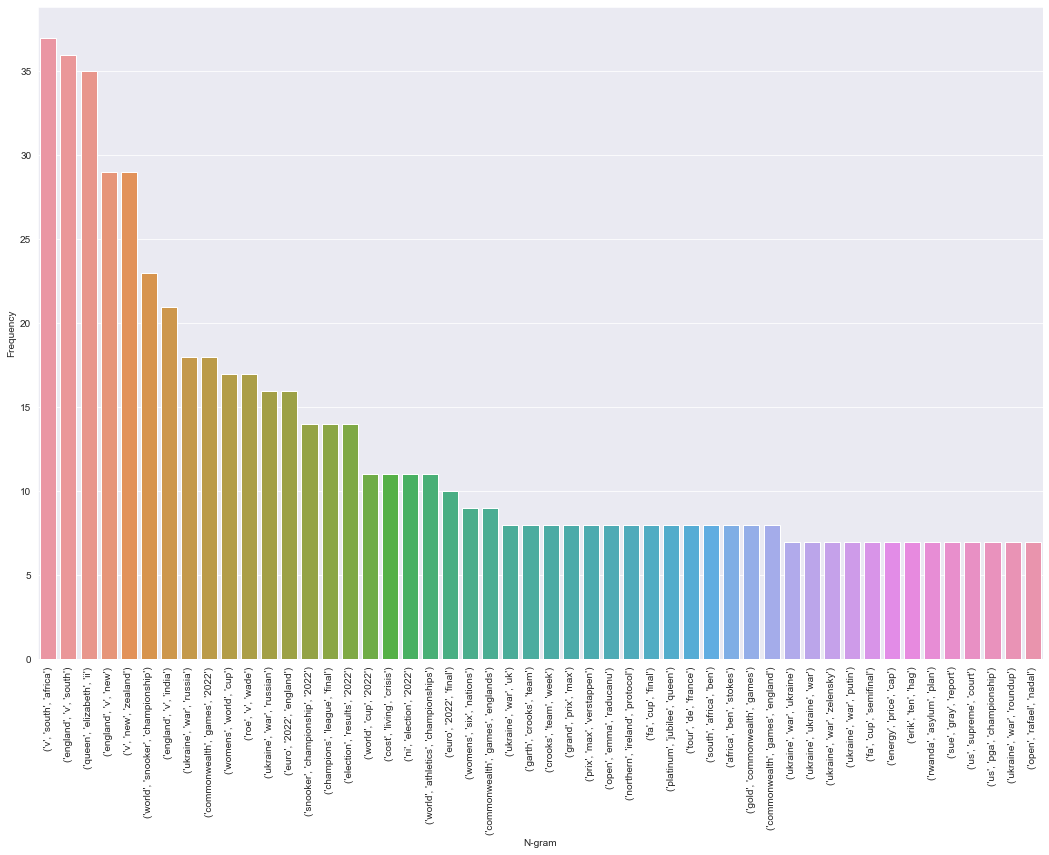

In [19]:
plt.figure(figsize=(18, 12))
sns.barplot(data=trigram_freq_title, x='N-gram', y='Frequency')
plt.xticks(rotation=90)

# Trends analyzing with pytrends

In [20]:
trends = TrendReq(hl='en-US', tz=360, retries=2, backoff_factor=0.1)
trends

In [21]:
timeframe = f'{data["pubDate"].min().strftime("%Y-%m-%d")} {data["pubDate"].max().strftime("%Y-%m-%d")}' # timeframe
timeframe

'2019-10-29 2022-09-18'

In [22]:
top_kws = list(map(lambda x: ' '.join(x[0]), bigrams_dist.most_common(5)))

In [27]:
if TRENDS: # rerun only on demand, since very long running code
    trend_data = pd.DataFrame()
    for kw in top_kws:
        trends.build_payload(kw_list=[kw], timeframe=timeframe)
        trend_data = pd.concat([trend_data, trends.interest_by_region()], axis=1)
        time.sleep(2)
        print(trends.interest_by_region().sort_values(by=[kw], ascending=False))
#     print(trend_data.sort_values(by=top_kws, ascending=False))

                          ukraine war
geoName                              
Papua New Guinea                  100
Malawi                             59
Zimbabwe                           30
Uganda                             27
Ghana                              20
...                               ...
Haiti                               0
Heard & McDonald Islands            0
Honduras                            0
Iceland                             0
Åland Islands                       0

[250 rows x 1 columns]
                 euro 2022
geoName                   
Iceland                100
Cameroon                80
North Macedonia         58
Côte d’Ivoire           52
Italy                   48
...                    ...
Honduras                 0
Hong Kong                0
Iran                     0
Iraq                     0
Åland Islands            0

[250 rows x 1 columns]
                england v
geoName                  
Ireland               100
Jersey                 86
Uni

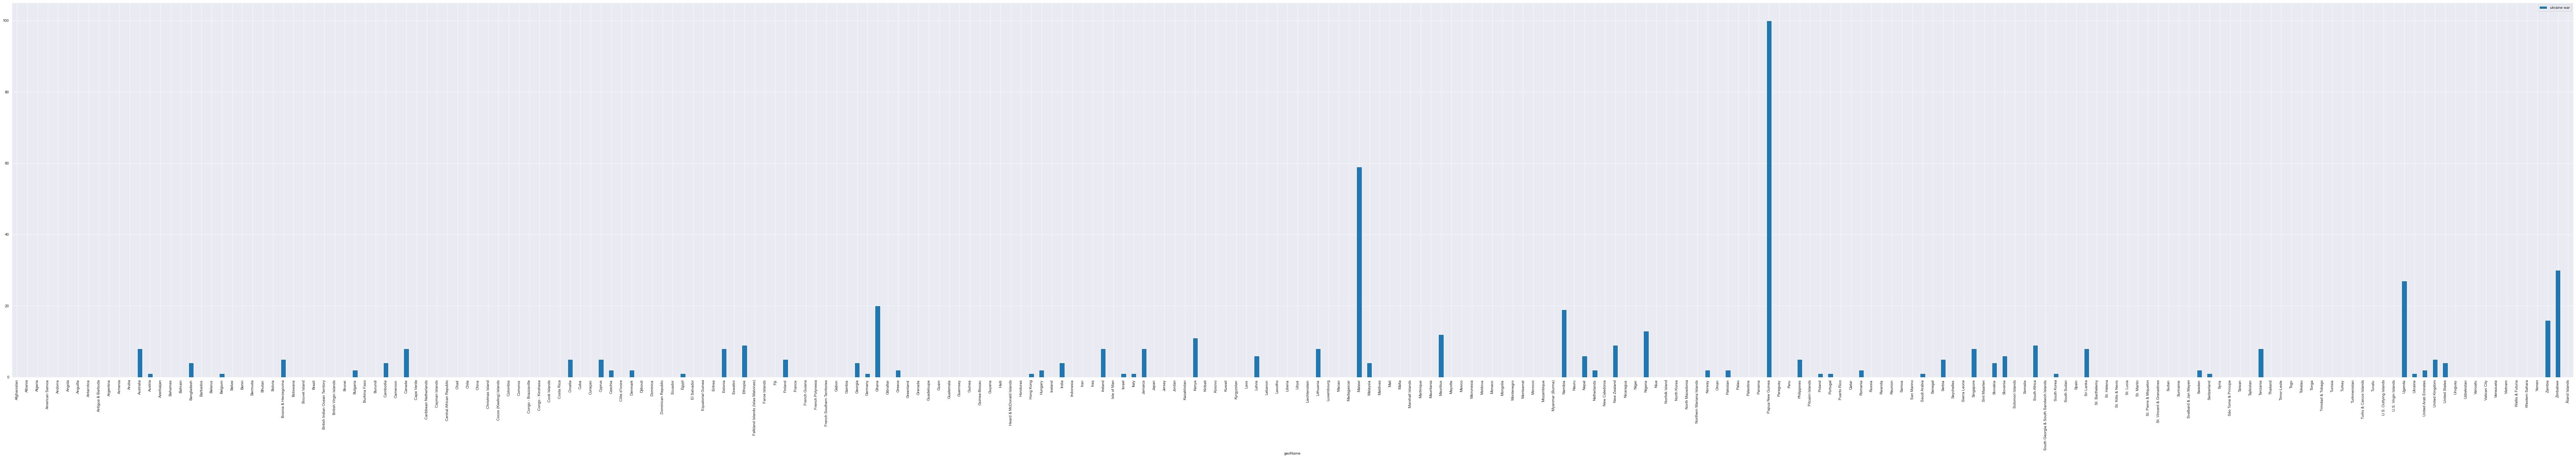

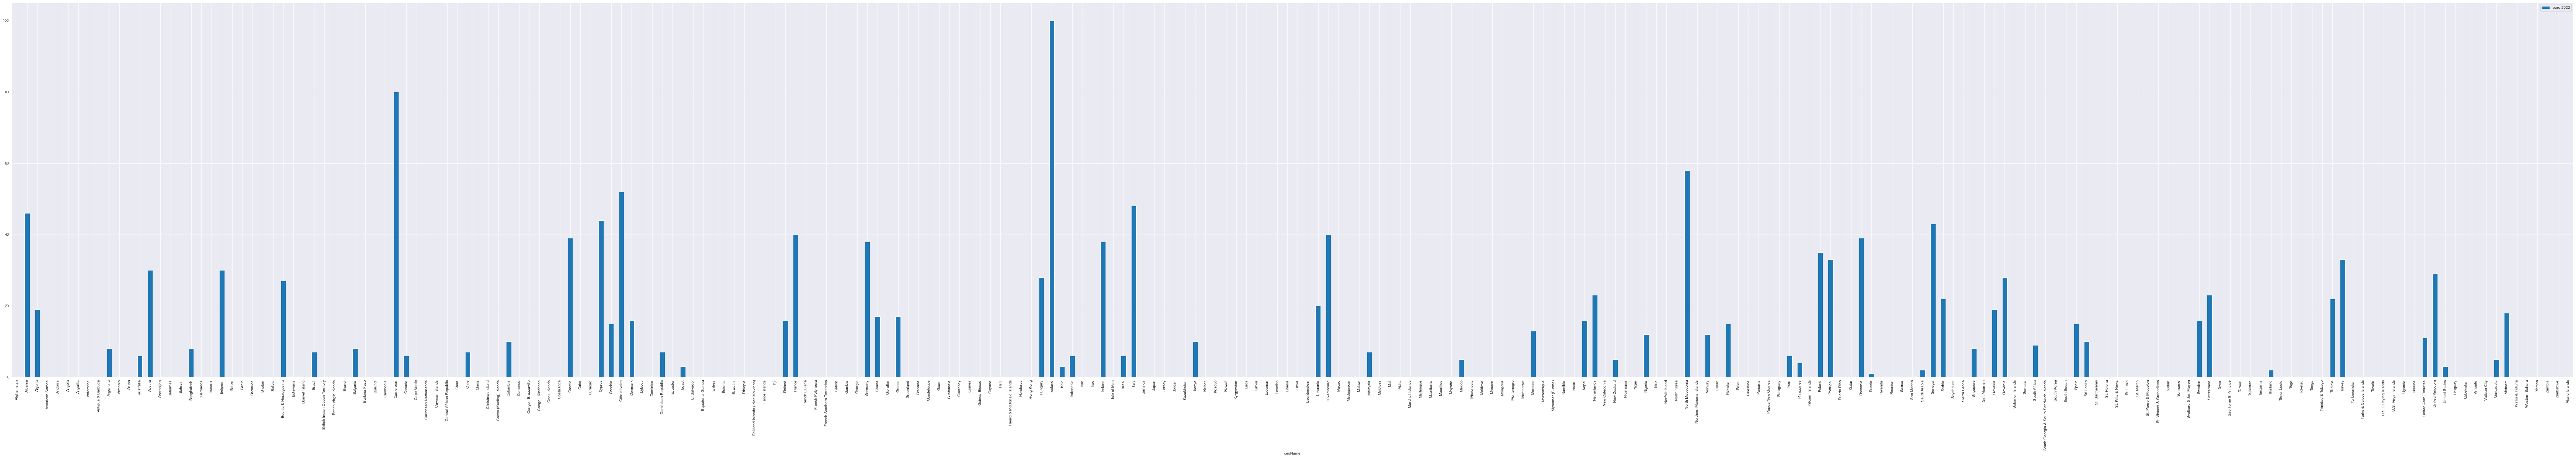

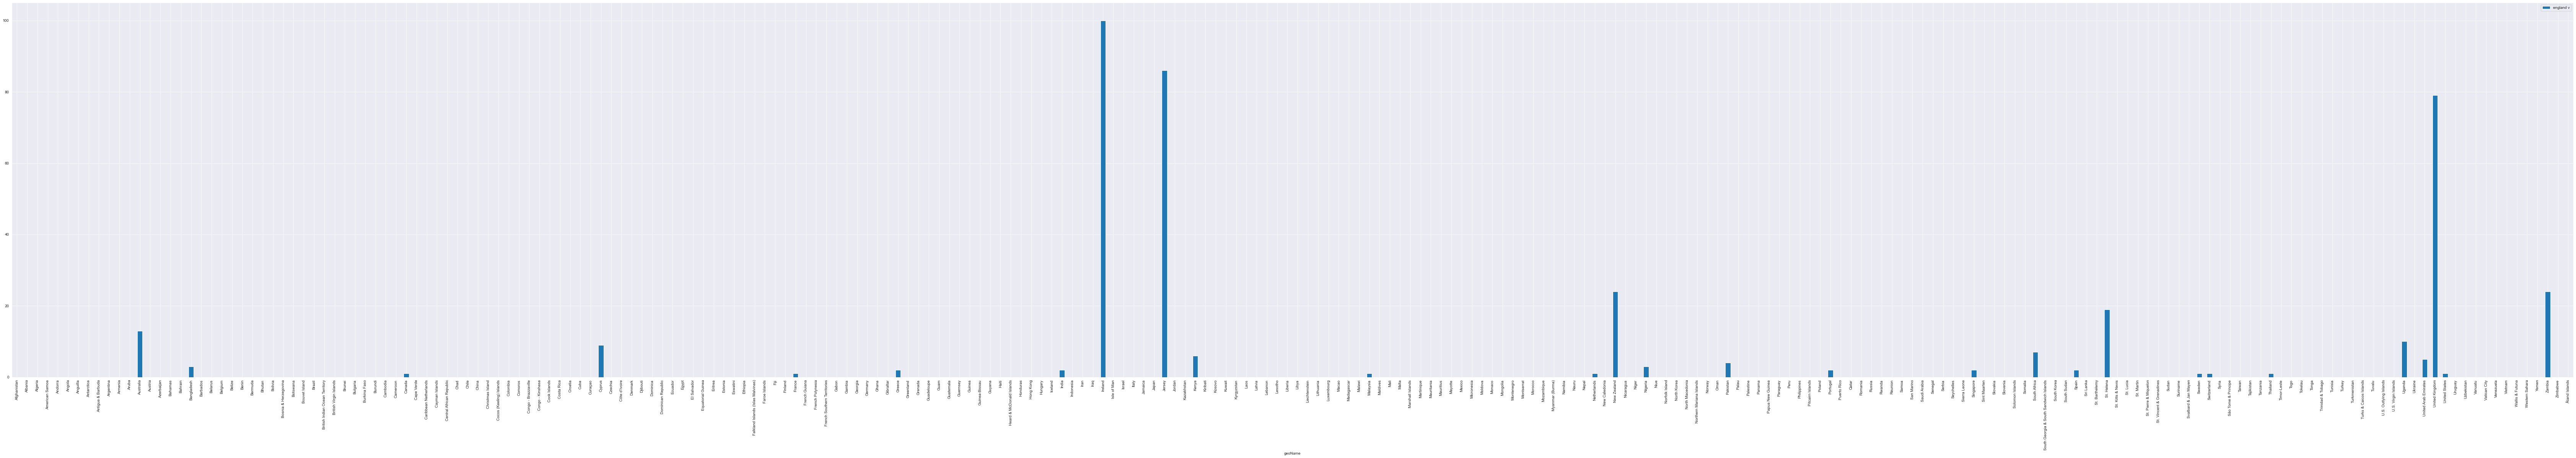

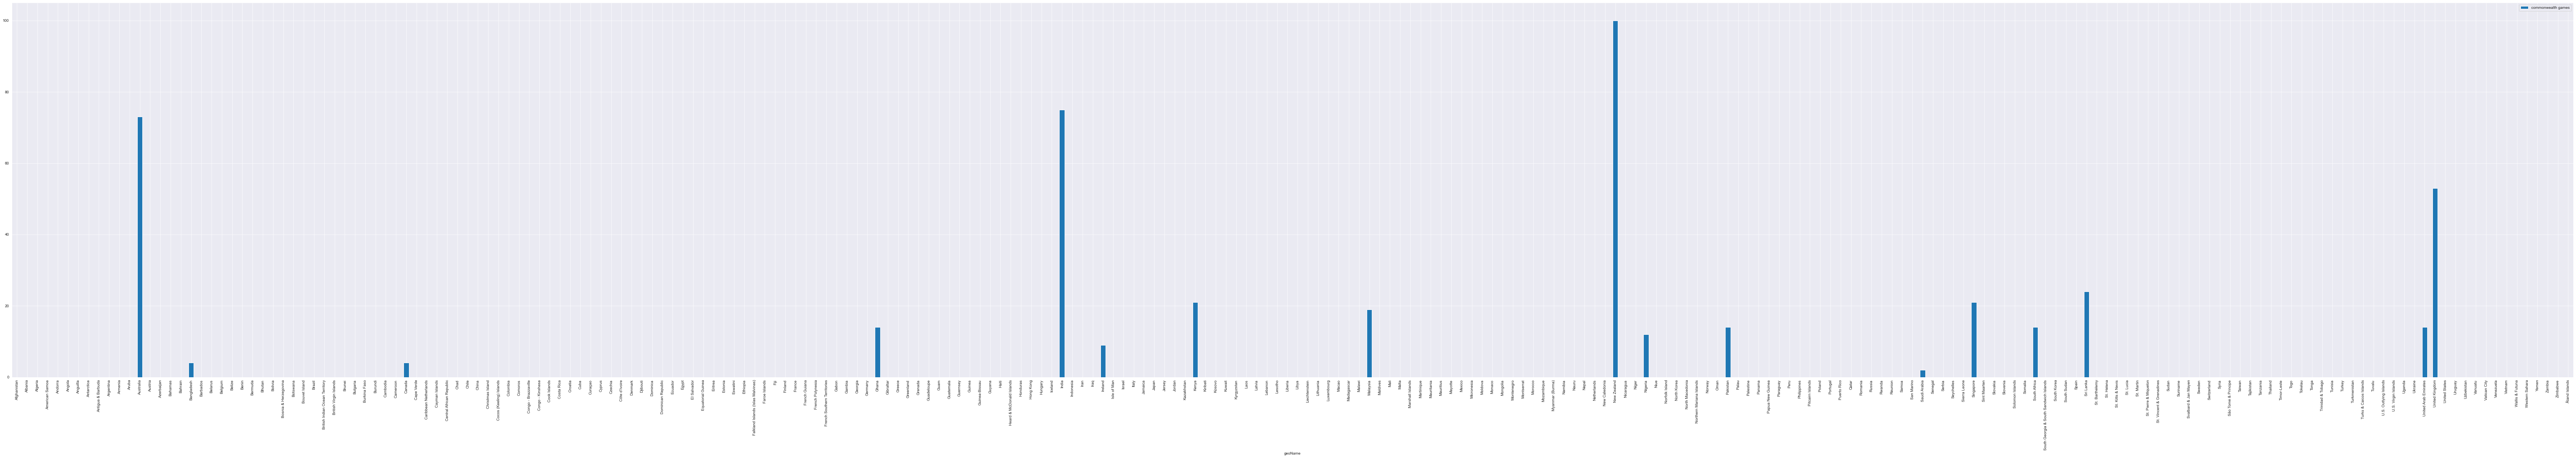

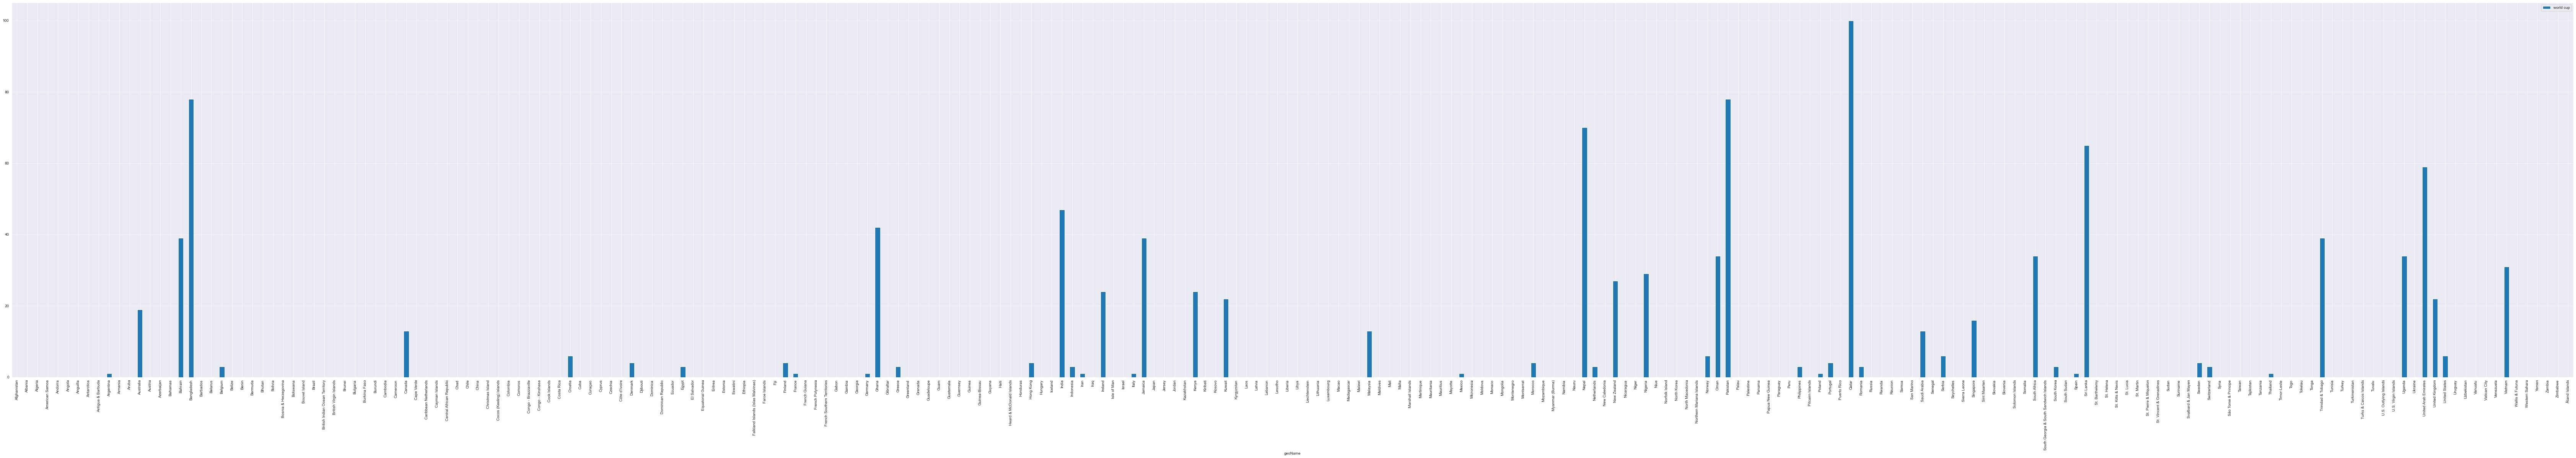

In [28]:
if TRENDS:
    for kw in top_kws:
        trend_data.reset_index().plot(x='geoName', y=kw, figsize=(120, 18), kind='bar')

# Top 25 countries to google the keywords

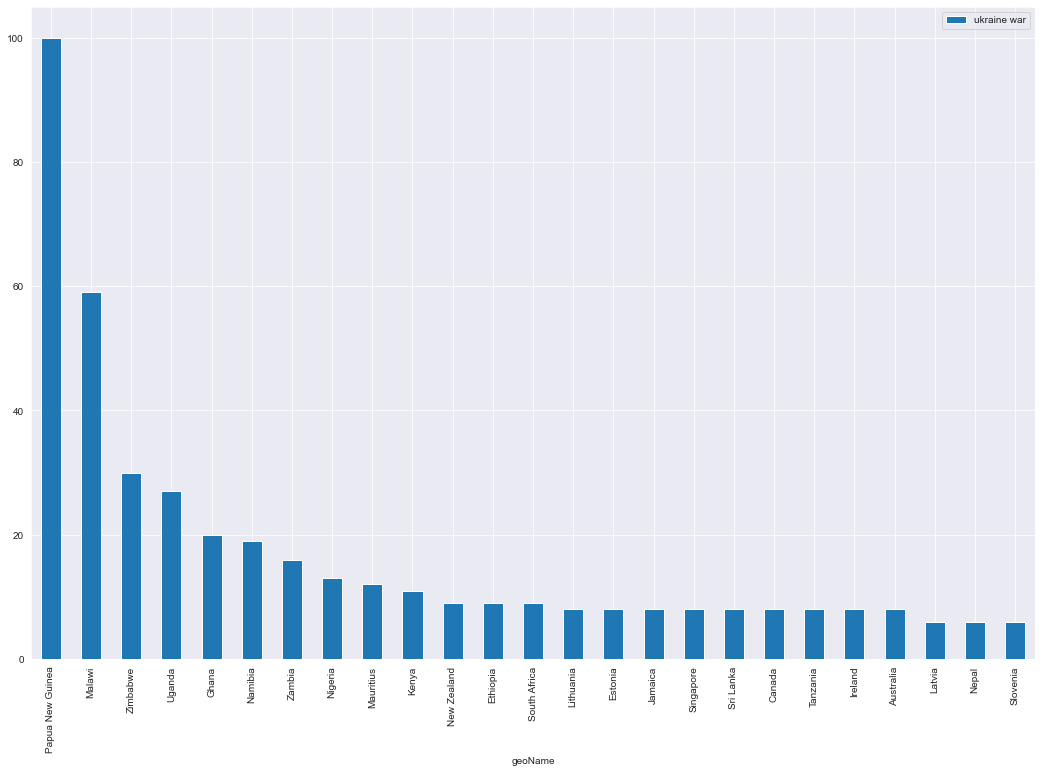

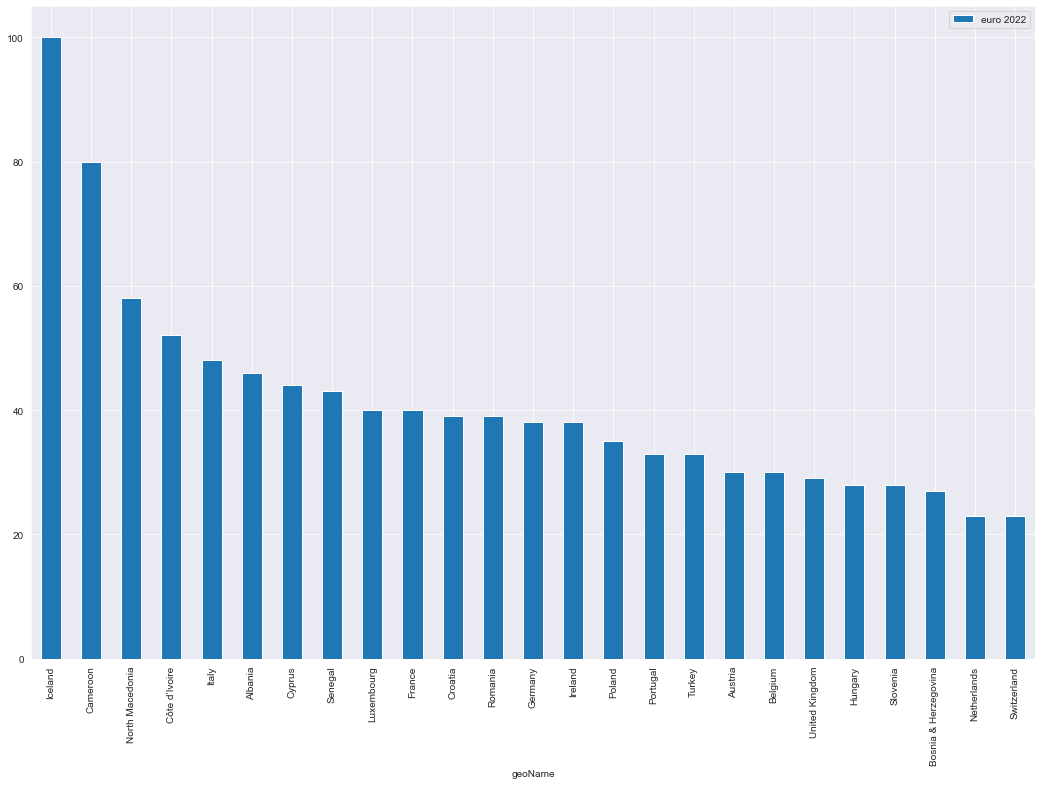

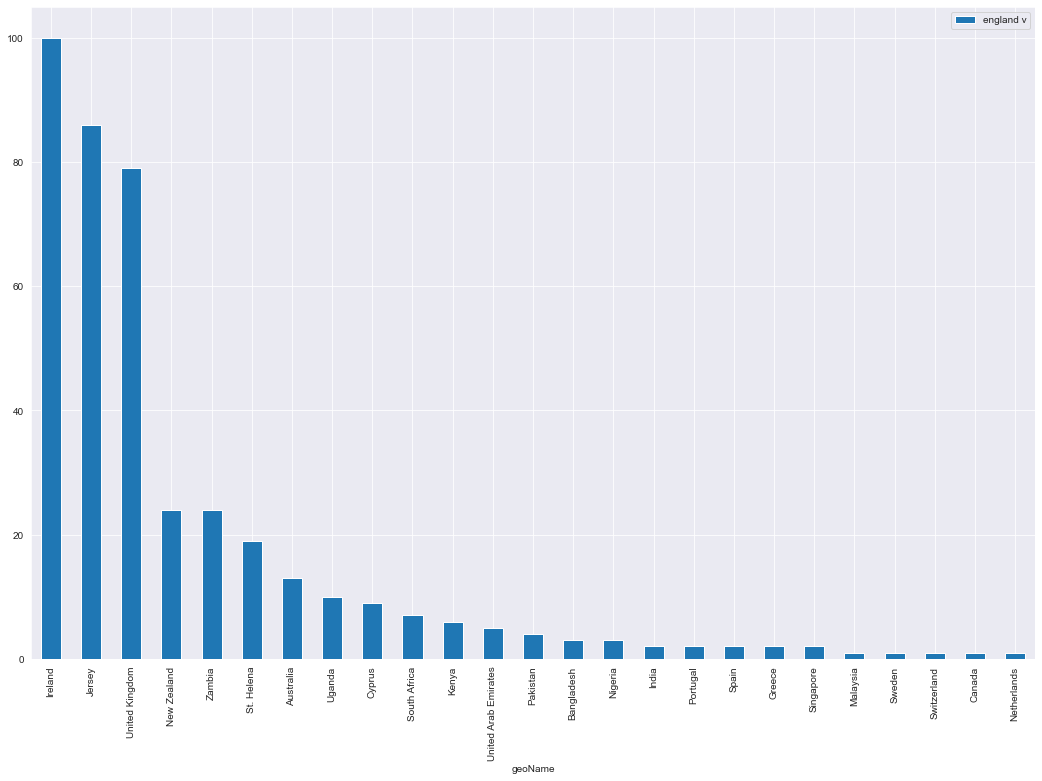

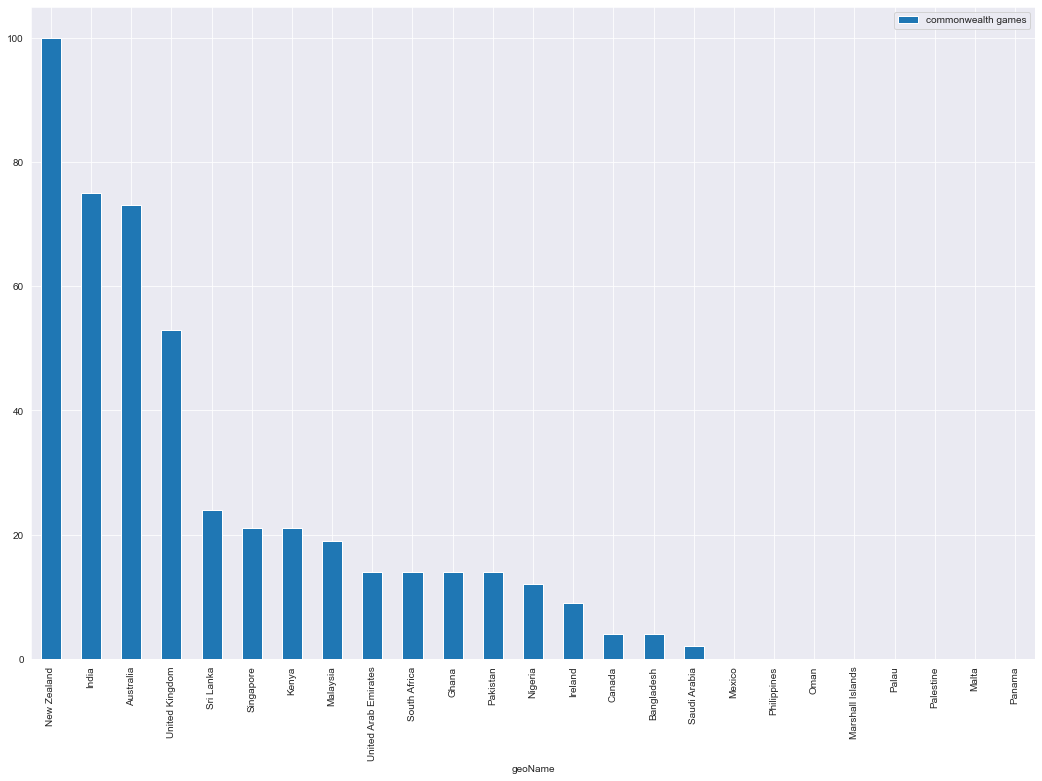

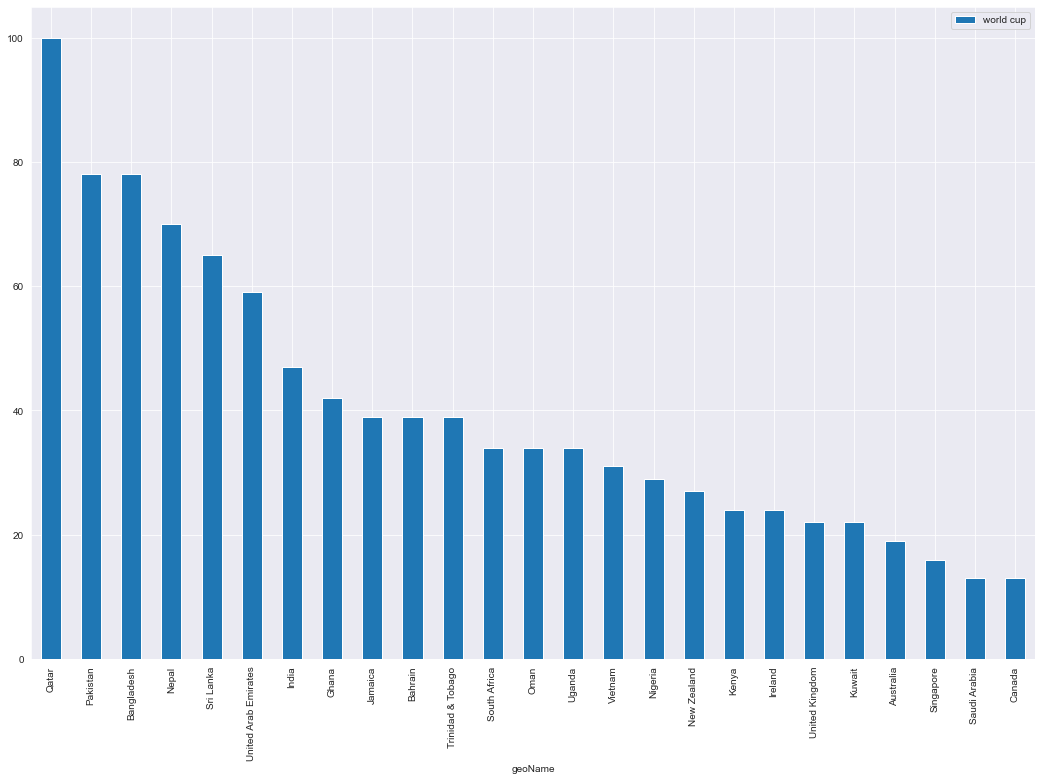

In [29]:
if TRENDS:
    for kw in top_kws:
        trend_data.sort_values(by=[kw], ascending=False)[:25].reset_index().plot(x='geoName', y=kw, figsize=(18, 12), kind='bar')

In [30]:
if TRENDS:
    for kw in top_kws:
        trend_tmp = trend_data.reset_index()
        trend_tmp = trend_tmp[trend_tmp[kw] > 0]

        fig = px.scatter_geo(trend_tmp, locations='geoName', color='geoName',
                             hover_name='geoName', size=kw,
                             projection='natural earth', locationmode='country names', title=kw)
        fig.show()

## Suggestions

In [31]:
suggestions_data = pd.DataFrame()
suggest_terms = pd.Series(dtype=str)
if TRENDS:
    for kw_idx in freq_title['Word'].index[:5]:
        kw = freq_title.loc[kw_idx, 'Word']
        suggests = pd.DataFrame(trends.suggestions(keyword=kw)).drop(columns=['mid'])
        
        suggest_terms = pd.concat([suggest_terms, pd.Series([kw] * len(suggests))])
        
        suggestions_data = pd.concat([suggestions_data, suggests])
        time.sleep(2)
suggestions_data = pd.concat([suggestions_data.reset_index(drop=True), suggest_terms.reset_index(drop=True)], axis=1)
suggestions_data

In [32]:
suggestions_data

title                    type  \
0                                        Ukraine              TV channel   
1                 Ukraine national football team           Football team   
2                Cabinet of Ministers of Ukraine          Governing body   
3                            Russo-Ukrainian War                     War   
4                  State Savings Bank of Ukraine                 Company   
5                          Golden State Warriors         Basketball team   
6                                           Hulk    Comic book character   
7                                           News         Broadcast genre   
8                                       Wardrobe                   Topic   
9                                           Wart                   Topic   
10                                       England  UK constituent country   
11                England national football team           Football team   
12                          New England Patriots  American football team   
13             England national rugby union team        Rugby union team   
14        England women's national football team           Football team   
15                    Olympic Games Beijing 2022           Olympic games   
16                          2022 Australian Open              Tournament   
17  2022 FIFA World Cup qualification - CONMEBOL              Tournament   
18                                      MacGyver       Television series   
19                                        Scream               2022 film   
20                     Die Hard with a Vengeance               1995 film   
21                                 The Professor               2018 film   
22                                Mercury Rising               1998 film   
23                              Simon Says Stamp                   Topic   
24                                  Charlie Says               2018 film   

          0  
0   ukraine  
1   ukraine  
2   ukraine  
3   ukraine  
4   ukraine  
5       war  
6       war  
7       war  
8       war  
9       war  
10  england  
11  england  
12  england  
13  england  
14  england  
15     2022  
16     2022  
17     2022  
18     2022  
19     2022  
20     says  
21     says  
22     says  
23     says  
24     says

## Related queries

In [35]:
if TRENDS: # rerun only on demand, since very long running code
    related_data = pd.DataFrame()
    for kw_idx in bigram_freq_title['N-gram'].index[:5]:
        kw = ' '.join(bigram_freq_title.loc[kw_idx, 'N-gram'])
        
        trends.build_payload(kw_list=[kw], timeframe=timeframe)
        related_queries = trends.related_queries()[kw]['top']
        related_data = pd.concat([related_data, pd.concat([related_queries, pd.Series([kw] * len(related_queries))], axis=1)])
        
        time.sleep(2)
related_data

query  value            0
0   war russia ukraine    100  ukraine war
1       russia ukraine    100  ukraine war
2               russia     95  ukraine war
3   russia war ukraine     95  ukraine war
4           russia war     92  ukraine war
..                 ...    ...          ...
20     rugby world cup     14    world cup
21             icc t20     13    world cup
22      2019 world cup     13    world cup
23            football     11    world cup
24  football world cup     11    world cup

[125 rows x 3 columns]

# Cleaning data (removing punctuation)

In [36]:
# lower and remove punctuation
data['title_cleaned'] = data['title'].str.lower() .apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]', '', x))
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  
0     ukraine angry zelensky vows to punish russian ...  
1     war in ukraine taking cover in a town under at...  
2              ukraine war catastrophic for global food  
3     manchester arena bombing saffie roussoss paren...  
4     ukraine conflict oil price soars to highest le...  
...                                                 ...  
7359  premiership harlequins 2730 saracens  sarries ...  
7360       the queue  and the expert who helped plan it  
7361    the cowboy and the queen who bonded over horses  
7362    queen amused by an americans breach of protocol  
7363  queen elizabeth iis special connection with wi...  

[7364 rows x 6 columns]

In [37]:
# remove redundant spaces
data['title_cleaned'] = data['title_cleaned'].str.strip()
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  
0     ukraine angry zelensky vows to punish russian ...  
1     war in ukraine taking cover in a town under at...  
2              ukraine war catastrophic for global food  
3     manchester arena bombing saffie roussoss paren...  
4     ukraine conflict oil price soars to highest le...  
...                                                 ...  
7359  premiership harlequins 2730 saracens  sarries ...  
7360       the queue  and the expert who helped plan it  
7361    the cowboy and the queen who bonded over horses  
7362    queen amused by an americans breach of protocol  
7363  queen elizabeth iis special connection with wi...  

[7364 rows x 6 columns]

In [38]:
data['title_cleaned'][0], data['title_cleaned'][1]

('ukraine angry zelensky vows to punish russian atrocities',
 'war in ukraine taking cover in a town under attack')

In [39]:
data['title_cleaned'].apply(len).describe()

count    7364.000000
mean       59.975014
std        12.980796
min        15.000000
25%        51.000000
50%        58.000000
75%        67.000000
max       139.000000
Name: title_cleaned, dtype: float64

# Lemmatization

In [40]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('civilians')

'civilian'

In [41]:
data['title_cleaned']=data['title_cleaned'].apply(lambda x: ' '.join(map(lemmatizer.lemmatize, filter(lambda w: w not in STOPWORDS, nltk.tokenize.word_tokenize(x)))))
data['title'][100], data['title_cleaned'][100]

('Cost of living: Warning UK faces biggest income squeeze in nearly 50 years',
 'cost living warning uk face biggest income squeeze nearly 50 year')

## Normalizing data

In [42]:
cv = CountVectorizer(analyzer='word')
cv_data = cv.fit_transform(data['title_cleaned'])
dtm_data = pd.DataFrame(cv_data.toarray(), columns=cv.get_feature_names())
dtm_data.index = data.index
dtm_data.head(5)

/Users/stepantytarenko/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



00  01  02  03  04  10  100  1000  10000  100000  ...  zombie  zombified  \
0   0   0   0   0   0   0    0     0      0       0  ...       0          0   
1   0   0   0   0   0   0    0     0      0       0  ...       0          0   
2   0   0   0   0   0   0    0     0      0       0  ...       0          0   
3   0   0   0   0   0   0    0     0      0       0  ...       0          0   
4   0   0   0   0   0   0    0     0      0       0  ...       0          0   

   zone  zoo  zoom  zulu  zurich  zuu  zverev  zwelithini  
0     0    0     0     0       0    0       0           0  
1     0    0     0     0       0    0       0           0  
2     0    0     0     0       0    0       0           0  
3     0    0     0     0       0    0       0           0  
4     0    0     0     0       0    0       0           0  

[5 rows x 10690 columns]

In [43]:
dtm_data.iloc[:, 500:]

agency  agenda  agent  agg  aggregate  aggression  aggressive  aging  \
0          0       0      0    0          0           0           0      0   
1          0       0      0    0          0           0           0      0   
2          0       0      0    0          0           0           0      0   
3          0       0      0    0          0           0           0      0   
4          0       0      0    0          0           0           0      0   
...      ...     ...    ...  ...        ...         ...         ...    ...   
7359       0       0      0    0          0           0           0      0   
7360       0       0      0    0          0           0           0      0   
7361       0       0      0    0          0           0           0      0   
7362       0       0      0    0          0           0           0      0   
7363       0       0      0    0          0           0           0      0   

      ago  agonising  ...  zombie  zombified  zone  zoo  zoom  zulu  zurich  \
0       0          0  ...       0          0     0    0     0     0       0   
1       0          0  ...       0          0     0    0     0     0       0   
2       0          0  ...       0          0     0    0     0     0       0   
3       0          0  ...       0          0     0    0     0     0       0   
4       0          0  ...       0          0     0    0     0     0       0   
...   ...        ...  ...     ...        ...   ...  ...   ...   ...     ...   
7359    0          0  ...       0          0     0    0     0     0       0   
7360    0          0  ...       0          0     0    0     0     0       0   
7361    0          0  ...       0          0     0    0     0     0       0   
7362    0          0  ...       0          0     0    0     0     0       0   
7363    0          0  ...       0          0     0    0     0     0       0   

      zuu  zverev  zwelithini  
0       0       0           0  
1       0       0           0  
2       0       0           0  
3       0       0           0  
4       0       0           0  
...   ...     ...         ...  
7359    0       0           0  
7360    0       0           0  
7361    0       0           0  
7362    0       0           0  
7363    0       0           0  

[7364 rows x 10190 columns]

# Wordclouds

In [44]:
# Function for generating word clouds
def generate_wordcloud(data, title, bg='black', colormap='Dark2', mask=None):
    wc = WordCloud(width=1600, height=1080, max_words=150, colormap=colormap, mask=mask, background_color=bg).generate_from_frequencies(data)
    plt.figure(figsize=(16,12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('\n'.join(wrap(title,60)),fontsize=26)
    plt.show()

In [34]:
ASSETS_PATH = './assets'

In [35]:
f100_mask = np.array(Image.open(ASSETS_PATH + '/100.png'))

In [36]:
latest100indexes = data.sort_values(by=['pubDate'], ascending=False).index

## Latest 100 titles

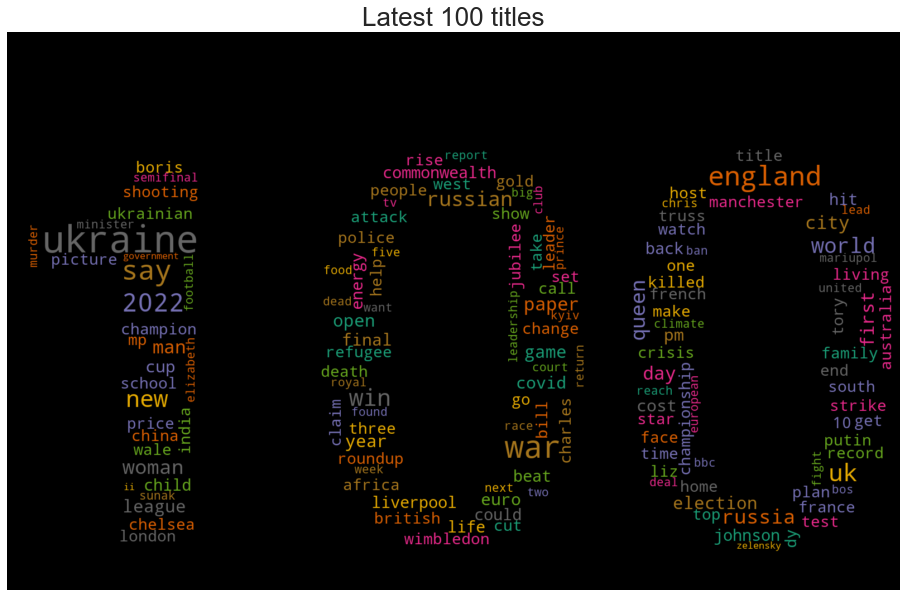

In [36]:
generate_wordcloud(dtm_data.loc[latest100indexes].T.sum(axis=1), 'Latest 100 titles', mask=f100_mask)

## Latest 500 titles

In [37]:
f500_mask = np.array(Image.open(ASSETS_PATH + '/500.png'))

In [38]:
latest500indexes = data.sort_values(by=['pubDate'], ascending=False).index

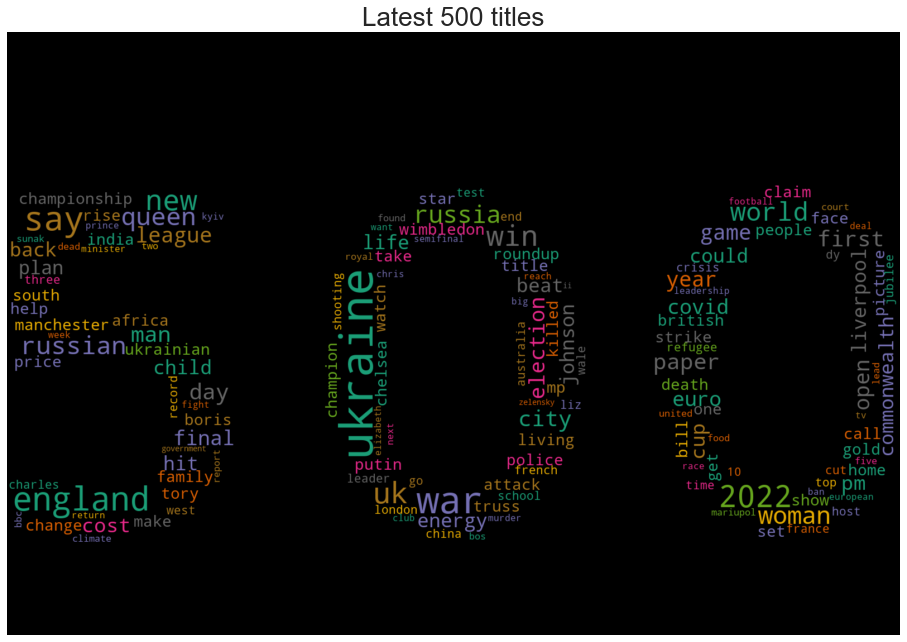

In [39]:
generate_wordcloud(dtm_data.loc[latest500indexes].T.sum(axis=1), 'Latest 500 titles', mask=f500_mask)

In [45]:
data['title_polarity'] = data['title_cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  title_polarity  
0     ukraine angry zelensky vow punish russian atro...       -0.250000  
1                  war ukraine taking cover town attack        0.000000  
2                  ukraine war catastrophic global food        0.000000  
3     manchester arena bombing saffie roussoss paren...        0.000000  
4     ukraine conflict oil price soar highest level ...        0.000000  
...                                                 ...             ...  
7359  premiership harlequin 2730 saracen sarries win...        0.183333  
7360                           queue expert helped plan        0.000000  
7361                          cowboy queen bonded horse        0.000000  
7362              queen amused american breach protocol        0.

In [40]:
data.describe()

title_polarity
count     7364.000000
mean         0.036574
std          0.237512
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000

## 20 most negative News

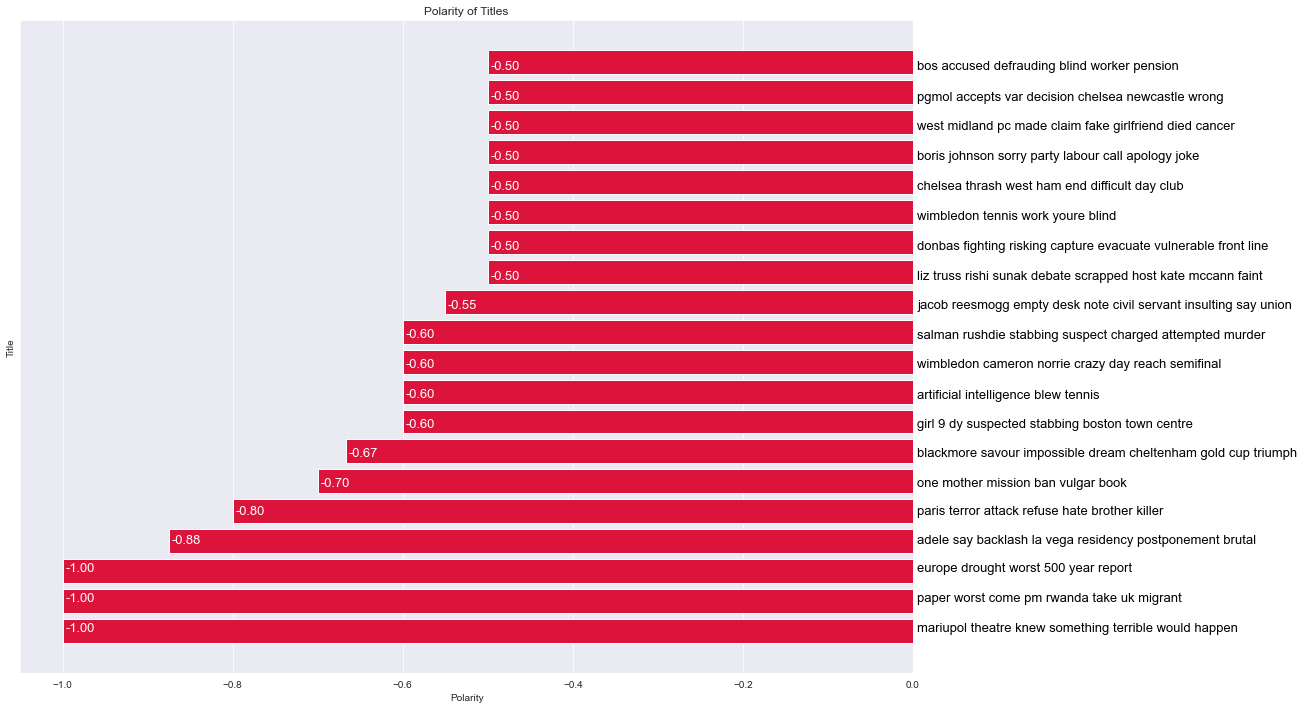

In [41]:
title_polarity_sorted = data['title_polarity'].sort_values(ascending=True).copy()[:200:10]

plt.figure(figsize=(16,12))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='crimson')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() - bar.get_width() / 2, str(data['title_cleaned'][polarity_idx]), va='center', fontsize=13, color='black')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() - bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='white')

plt.yticks([])
plt.show()

In [42]:
title_polarity_sorted

516    -1.000000
1560   -1.000000
6471   -1.000000
4475   -0.875000
4486   -0.800000
1112   -0.700000
576    -0.666667
5463   -0.600000
3283   -0.600000
4612   -0.600000
6105   -0.600000
1889   -0.550000
5382   -0.500000
2340   -0.500000
4541   -0.500000
245    -0.500000
1727   -0.500000
6031   -0.500000
6878   -0.500000
302    -0.500000
Name: title_polarity, dtype: float64

In [43]:
thumb_down_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png').transpose(method=Image.FLIP_TOP_BOTTOM))
thumb_down_mask-=1
thumb_down_mask[thumb_down_mask == 0] = 255

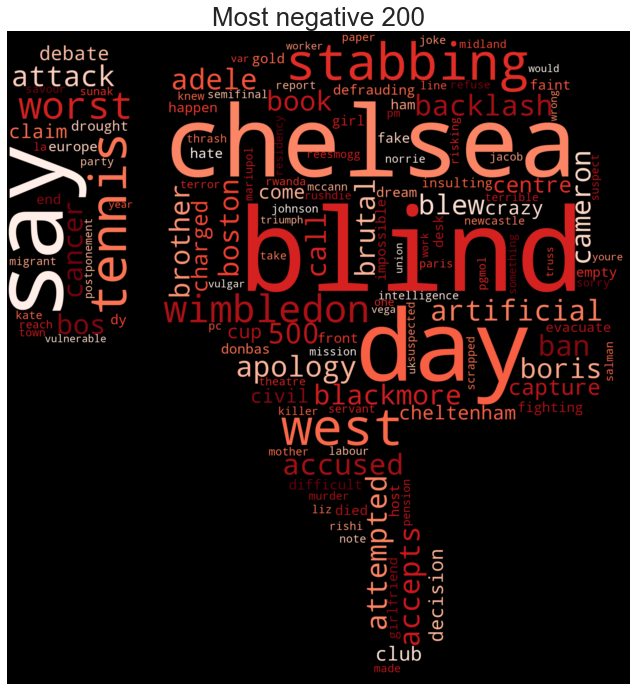

In [45]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most negative 200', colormap='Reds', mask=thumb_down_mask)

# 20 most positive news

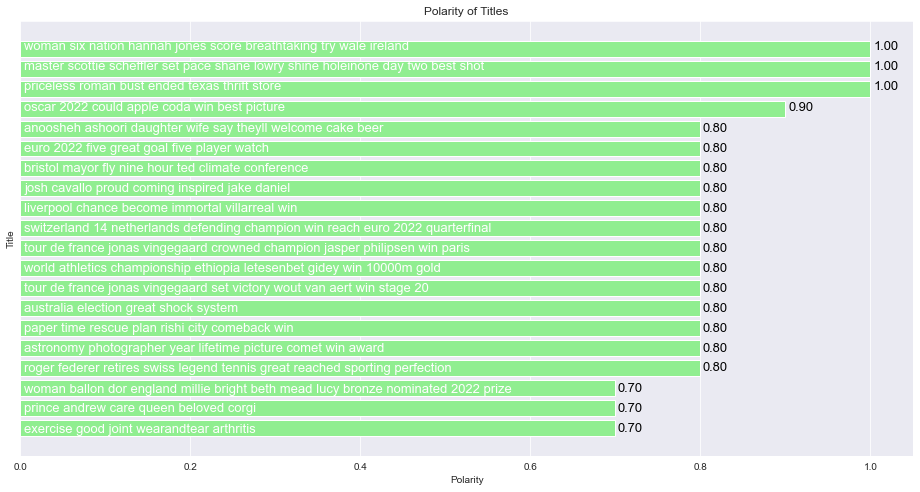

In [44]:
title_polarity_sorted = data['title_polarity'].sort_values(ascending=True).copy()[-200::10]

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Title')
plt.title('Polarity of Titles')
polarity_graph=plt.barh(np.arange(len(title_polarity_sorted.index)), title_polarity_sorted, color='lightgreen')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(0.005, bar.get_y() + bar.get_width() / 2, str(data['title_cleaned'][polarity_idx]), va='center', fontsize=13, color='white')

for bar, polarity_idx in zip(polarity_graph, title_polarity_sorted.index):
    plt.text(bar.get_width() + 0.003, bar.get_y() + bar.get_width() / 2,'{:.2f}'.format(title_polarity_sorted[polarity_idx]), va='center', fontsize=13, color='black')
    
plt.yticks([])
plt.show()

In [45]:
thumb_up_mask = np.array(Image.open(ASSETS_PATH + '/thumb-up.png'))
thumb_up_mask-=1
thumb_up_mask[thumb_up_mask == 0] = 255

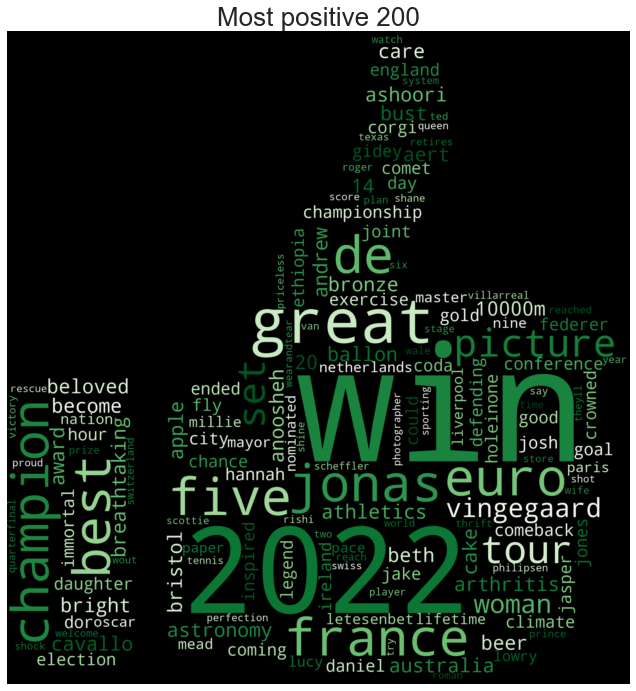

In [48]:
generate_wordcloud(dtm_data.loc[title_polarity_sorted.index].T.sum(axis=1), 'Most positive 200', colormap='Greens', mask=thumb_up_mask)

# Lemmatization and filtering

In [46]:
word_freq_data_normalized = dtm_data.T
word_freq_data_normalized

0     1     2     3     4     5     6     7     8     9     ...  \
00             0     0     0     0     0     0     0     0     0     0  ...   
01             0     0     0     0     0     0     0     0     0     0  ...   
02             0     0     0     0     0     0     0     0     0     0  ...   
03             0     0     0     0     0     0     0     0     0     0  ...   
04             0     0     0     0     0     0     0     0     0     0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
zulu           0     0     0     0     0     0     0     0     0     0  ...   
zurich         0     0     0     0     0     0     0     0     0     0  ...   
zuu            0     0     0     0     0     0     0     0     0     0  ...   
zverev         0     0     0     0     0     0     0     0     0     0  ...   
zwelithini     0     0     0     0     0     0     0     0     0     0  ...   

            7354  7355  7356  7357  7358  7359  7360  7361  7362  7363  
00             0     0     0     0     0     0     0     0     0     0  
01             0     0     0     0     0     0     0     0     0     0  
02             0     0     0     0     0     0     0     0     0     0  
03             0     0     0     0     0     0     0     0     0     0  
04             0     0     0     0     0     0     0     0     0     0  
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
zulu           0     0     0     0     0     0     0     0     0     0  
zurich         0     0     0     0     0     0     0     0     0     0  
zuu            0     0     0     0     0     0     0     0     0     0  
zverev         0     0     0     0     0     0     0     0     0     0  
zwelithini     0     0     0     0     0     0     0     0     0     0  

[10690 rows x 7364 columns]

In [47]:
word_freq_data = pd.DataFrame(word_freq_data_normalized.sum(axis=1).reset_index()).rename(columns={'index': 'word', 0: 'freq'})
word_freq_data

word  freq
0              00     6
1              01    16
2              02     5
3              03     5
4              04     7
...           ...   ...
10685        zulu     1
10686      zurich     2
10687         zuu     1
10688      zverev     2
10689  zwelithini     1

[10690 rows x 2 columns]

In [48]:
nltk_lems = [lemmatizer.lemmatize(word) for word in nltk_words.words()] #stem the #words in the NLTK corpus so that they’re equivalent to the words in #the dataframe
df_nltk_words = pd.DataFrame() # make a new dataframe with the stemmed #NLTK words
df_nltk_words['word'] = nltk_lems
word_freq_data = word_freq_data[word_freq_data['word'].isin(df_nltk_words['word'])] #keep only #those in the stemmed NLTK corpus
word_freq_data

word  freq
353      abandon     1
354    abandoned     9
356        abbey     4
361    abdominal     2
362       abduct     1
...          ...   ...
10675   zimbabwe     3
10680     zombie     1
10682       zone     7
10683        zoo     8
10684       zoom     1

[5624 rows x 2 columns]

In [49]:
word_freq_data[word_freq_data['freq'] >= word_freq_data['freq'].quantile(0.4)]

word  freq
354    abandoned     9
356        abbey     4
361    abdominal     2
368      ability     2
371     abortion    42
...          ...   ...
10651        zak     3
10667       zero     4
10675   zimbabwe     3
10682       zone     7
10683        zoo     8

[3378 rows x 2 columns]

# TFiDF Vectorization

In [50]:
stopwords = list(word_freq_data[word_freq_data['freq'] < word_freq_data['freq'].quantile(0.4)]['word'])
vec_vocab = list(word_freq_data[word_freq_data['freq'] >= word_freq_data['freq'].quantile(0.4)]['word'])

In [51]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=stopwords, vocabulary=vec_vocab)
tfidf_vectorizer

TfidfVectorizer(stop_words=['abandon', 'abduct', 'able', 'aboriginal',
                            'absence', 'absentee', 'abstain', 'abuser',
                            'acapulco', 'accidental', 'according', 'accordion',
                            'accountant', 'accuse', 'accuser', 'achievement',
                            'acid', 'acrobat', 'acting', 'actively',
                            'acupuncture', 'addition', 'administration',
                            'administrator', 'admire', 'admission', 'admit',
                            'admitted', 'adrift', 'advocacy', ...],
                vocabulary=['abandoned', 'abbey', 'abdominal', 'ability',
                            'abortion', 'abroad', 'abu', 'abuse', 'abusive',
                            'academy', 'accept', 'accepted', 'access',
                            'accident', 'account', 'accusation', 'accused',
                            'ace', 'achieve', 'across', 'act', 'action',
                            'activist', 'actor', 'actress', 'actually', 'ad',
                            'add', 'added', 'addiction', ...])

In [52]:
tfidf_matrix = tfidf_vectorizer.fit_transform(data['title_cleaned'])
tfidf_matrix

<7364x3378 sparse matrix of type '<class 'numpy.float64'>'
	with 35299 stored elements in Compressed Sparse Row format>

In [53]:
tfidf_data = pd.DataFrame(tfidf_matrix.toarray())
tfidf_data

0     1     2     3     4     5     6     7     8     9     ...  3368  \
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
7359   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7360   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7361   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7362   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
7363   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   

      3369  3370  3371  3372  3373  3374  3375  3376  3377  
0      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
1      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...    ...   ...   ...   ...   ...   ...   ...   ...   ...  
7359   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7360   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7361   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7362   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
7363   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[7364 rows x 3378 columns]

In [56]:
feature_names = tfidf_vectorizer.get_feature_names_out()
feature_names

array(['abandoned', 'abbey', 'abdominal', ..., 'zimbabwe', 'zone', 'zoo'],
      dtype=object)

In [57]:
tfidf_data.columns = feature_names
tfidf_data

abandoned  abbey  abdominal  ability  abortion  abroad  abu  abuse  \
0           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
1           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
2           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
3           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
4           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
...         ...    ...        ...      ...       ...     ...  ...    ...   
7359        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7360        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7361        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7362        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7363        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   

      abusive  academy  ...  yes  yet  york  young  youth  zak  zero  \
0         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
1         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
2         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
3         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
4         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
...       ...      ...  ...  ...  ...   ...    ...    ...  ...   ...   
7359      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7360      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7361      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7362      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7363      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   

      zimbabwe  zone  zoo  
0          0.0   0.0  0.0  
1          0.0   0.0  0.0  
2          0.0   0.0  0.0  
3          0.0   0.0  0.0  
4          0.0   0.0  0.0  
...        ...   ...  ...  
7359       0.0   0.0  0.0  
7360       0.0   0.0  0.0  
7361       0.0   0.0  0.0  
7362       0.0   0.0  0.0  
7363       0.0   0.0  0.0  

[7364 rows x 3378 columns]

# PCA?

In [59]:
pca = PCA(n_components=100)
vec_matrix_pca = pca.fit_transform(tfidf_matrix)
vec_matrix_pca

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

# Nope, TruncatedSVD :)

### during the experiments following configurations were tried:

* 1000 components - 10 clusters

* 100 components - 10 clusters

* 50 components - 10 clusters

* 100 components - 5 clusters

* 100 components - 15 clusters

In [58]:
tsvd = TruncatedSVD(n_components=100, random_state=37)
vec_matrix_tsvd = tsvd.fit_transform(tfidf_matrix)
vec_matrix_tsvd

array([[ 0.00260649,  0.00340618, -0.00486001, ..., -0.00660094,
         0.01307863,  0.00381705],
       [ 0.26523225, -0.09263284,  0.0533547 , ..., -0.000541  ,
         0.01698924,  0.00682664],
       [ 0.33417714, -0.12769132,  0.06898211, ...,  0.00588477,
         0.0354091 , -0.0035414 ],
       ...,
       [ 0.02569699,  0.0596302 , -0.23923432, ..., -0.00688321,
         0.00599866, -0.00412703],
       [ 0.02162143,  0.04796513, -0.18903309, ..., -0.0644623 ,
         0.00545485, -0.055077  ],
       [ 0.02255858,  0.05676324, -0.14605529, ..., -0.04142721,
         0.01613194,  0.01139841]])

In [59]:
pd.DataFrame(vec_matrix_tsvd)

0         1         2         3         4         5         6   \
0     0.002606  0.003406 -0.004860 -0.002067 -0.001669  0.001824 -0.001300   
1     0.265232 -0.092633  0.053355  0.014538  0.037300  0.012906  0.012633   
2     0.334177 -0.127691  0.068982  0.020531  0.049125  0.012740 -0.018507   
3     0.007351  0.003119 -0.007808 -0.000276 -0.004147 -0.000636 -0.002487   
4     0.036514  0.004622 -0.020283 -0.005785 -0.010595  0.007263 -0.023945   
...        ...       ...       ...       ...       ...       ...       ...   
7359  0.031529  0.141647  0.093145  0.047634 -0.035672  0.011395  0.081840   
7360  0.020643  0.014477 -0.052392  0.009402 -0.027585 -0.012678 -0.020209   
7361  0.025697  0.059630 -0.239234  0.304170  0.208541 -0.076264  0.045872   
7362  0.021621  0.047965 -0.189033  0.230240  0.151966 -0.062258  0.029883   
7363  0.022559  0.056763 -0.146055  0.175825  0.123945 -0.056362  0.029729   

            7         8         9   ...        90        91        92  \
0    -0.009507  0.000214  0.002125  ...  0.003089 -0.004687  0.001711   
1    -0.002747  0.008244 -0.049347  ... -0.048024 -0.042373 -0.018013   
2    -0.033968  0.044866 -0.079035  ...  0.040349 -0.026430 -0.189420   
3    -0.005610 -0.000142 -0.002984  ...  0.033855  0.007386 -0.026561   
4    -0.052917  0.014995  0.015014  ... -0.030072  0.121768 -0.052373   
...        ...       ...       ...  ...       ...       ...       ...   
7359  0.009941  0.121207  0.025608  ...  0.001250  0.009857 -0.005464   
7360 -0.030333  0.010224  0.032642  ...  0.024315  0.011520  0.003741   
7361  0.046103  0.020731  0.013562  ... -0.023228 -0.017013 -0.025997   
7362  0.032401  0.021696  0.011748  ... -0.008560 -0.038230 -0.004683   
7363  0.034812  0.028876  0.008227  ...  0.008312  0.020127  0.015984   

            93        94        95        96        97        98        99  
0    -0.003120  0.008617 -0.005308 -0.012721 -0.006601  0.013079  0.003817  
1    -0.029447 -0.020069 -0.024598  0.000961 -0.000541  0.016989  0.006827  
2     0.036608 -0.044767 -0.037465  0.072283  0.005885  0.035409 -0.003541  
3     0.010522 -0.017156 -0.016399  0.034568 -0.022161 -0.052123  0.004083  
4     0.034386  0.024459  0.022309 -0.052545 -0.059741  0.004516  0.065519  
...        ...       ...       ...       ...       ...       ...       ...  
7359  0.003045 -0.017064 -0.003623 -0.016724 -0.000783 -0.000321 -0.004593  
7360  0.017075  0.011557 -0.006573  0.007832 -0.007077  0.013299  0.002059  
7361 -0.006864 -0.003861  0.015908  0.004796 -0.006883  0.005999 -0.004127  
7362 -0.045754  0.029662  0.009388 -0.024190 -0.064462  0.005455 -0.055077  
7363 -0.057816  0.019215 -0.032886 -0.031804 -0.041427  0.016132  0.011398  

[7364 rows x 100 columns]

# Clustering

## KMeans

In [60]:
clst10 = KMeans(n_clusters=10, verbose=0, random_state=37)
clst10.fit(vec_matrix_tsvd)

KMeans(n_clusters=10, random_state=37)

In [61]:
data['label'] = clst10.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  title_polarity  label  
0     ukraine angry zelensky vow punish russian atro...       -0.250000      3  
1                  war ukraine taking cover town attack        0.000000      5  
2                  ukraine war catastrophic global food        0.000000      5  
3     manchester arena bombing saffie roussoss paren...        0.000000      3  
4     ukraine conflict oil price soar highest level ...        0.000000      3  
...                                                 ...             ...    ...  
7359  premiership harlequin 2730 saracen sarries win...        0.183333      3  
7360                           queue expert helped plan        0.000000      3  
7361                          cowboy queen bonded horse        0.000000     

In [62]:
labels_count_data = data[['title', 'label']].groupby(['label', 'title']).count()
labels_count_data

Empty DataFrame
Columns: []
Index: [(0, 'Rise in Muslim families' seeking Ramadan food help), (0, A Ukrainian man has to choose between his family and his country), (0, Aiden Aslin: Family appeal for safety of Briton 'captured in Ukraine'), (0, Archie Battersbee's family granted more time to appeal against ruling), (0, Archie Battersbee: Family devastated as legal routes exhausted), (0, Archie Battersbee: Family seek permission for hospice move), (0, Australia landslide: Tributes paid to UK family after deaths in Blue Mountains), (0, Avabai Wadia: The lawyer who became India’s family planning pioneer), (0, Bangladesh suspected poisoning: Woman, 20, third in family to die), (0, Bengaluru floods: How families struggled to find help as India's IT capital drowned), (0, Bodies of Dom Phillips and Bruno Pereira returned to families), (0, Brentford's Rico Henry and Ivan Toney say their families were racially abused at Everton), (0, British brothers die on family holiday in Germany), (0, Charity uses online returns to help hard-up families), (0, China plane crash: Rescuers search for survivors as families await news), (0, Chris Kaba family says officer suspension too slow after shooting), (0, Cost of living: The family who gave up a car to cycle every day), (0, Cost of living: Two-child families paying £400 a month more), (0, Energy prices: Fears and cutbacks as hike hits disabled families), (0, Families face debt squeeze as prices keep rising), (0, Families in Nottingham maternity inquiry hit out at review), (0, Family courts: One fifth of divorces wrongly ending up in court - top judge), (0, Family of Sikh priest attacked in Manchester appeal for help), (0, Family separated by war in Ukraine finally reunited), (0, Fontaines DC: How a song by the band helped a grieving family to heal), (0, Gracie Spinks: Receipt could have traced killer - family), (0, Grenada: Confronting my family’s slave-owning past), (0, Grenfell: Why are families still waiting for justice?), (0, Harry Dunn: Family's bid for answers three years on from crash death), (0, Homes for Ukraine: Family's 'torturous' wait for a UK visa), (0, Homes for Ukraine: Robert Jenrick takes in Ukrainian refugee family), (0, How a family of 14 is coping with rising costs), (0, In one of the poorest slums in Argentina, families rely on a huge landfill site for food.), (0, In pictures: The Royal Family at Jubilee celebrations), (0, India and Pakistan: Tales of partition trauma bringing families closer), (0, Israeli police accused of violence towards shot Palestinian's family), (0, John Peel's family selling rare items from his archive), (0, KwaZulu-Natal floods: The South African family who lost nine children), (0, Lakhimpur: India family shattered by rape and murder of Dalit sisters), (0, Leeds Festival death: Family pay tribute to David Celino, 16), (0, Man admits stabbing Bermondsey family of four but denies murder), (0, Manchester Arena bomb family 'living the best lives they can'), (0, Memory boxes help families remember lost voices), (0, Montenegro: Gunman kills 10 after family dispute), (0, Olivia family ask 'who took our baby away from us?'), (0, Pakistan floods: Time running out for families in Sindh), (0, Paul Rusesabagina: Hotel Rwanda hero's family files $400m US lawsuit), (0, Philippines election: Marcos family eye return to power as country votes), (0, Ricketts family offers to meet Chelsea fans amid criticism of potential ownership), (0, Royal Family greet Queen Elizabeth II's coffin at Buckingham Palace), (0, Royal Family tree: William confirmed as Prince of Wales), (0, Royal Family: First day at school for George, Charlotte and Louis), (0, Shaun Pinner: Family devastated by Donetsk 'show trial'), (0, Shireen Abu Aqla: US report on journalist's death unacceptable, family says), (0, Spring Statement: One family's cost of living experience), (0, Star Hobson and Arthur Labinjo-Hughes: Family concerns 'disregarded' - report), (0, The Capitol riot trial that tore a family a

In [63]:
assign_ratio = labels_count_data.reset_index()['label'].value_counts() / labels_count_data.shape[0]
assign_ratio

3    0.776209
5    0.055133
8    0.026752
9    0.025394
2    0.025258
1    0.023628
7    0.020913
4    0.020098
6    0.014938
0    0.011678
Name: label, dtype: float64

In [64]:
assign_ratio.sum()

1.0

In [65]:
flat_labels_count_data = labels_count_data.reset_index()
for i in assign_ratio.index:
    flat_labels_count_data.loc[flat_labels_count_data['label'] == i, 'ratio'] = assign_ratio.loc[i]
flat_labels_count_data.groupby(['label', 'ratio', 'title']).first(5)

Empty DataFrame
Columns: []
Index: [(0, 0.011678435632808256, 'Rise in Muslim families' seeking Ramadan food help), (0, 0.011678435632808256, A Ukrainian man has to choose between his family and his country), (0, 0.011678435632808256, Aiden Aslin: Family appeal for safety of Briton 'captured in Ukraine'), (0, 0.011678435632808256, Archie Battersbee's family granted more time to appeal against ruling), (0, 0.011678435632808256, Archie Battersbee: Family devastated as legal routes exhausted), (0, 0.011678435632808256, Archie Battersbee: Family seek permission for hospice move), (0, 0.011678435632808256, Australia landslide: Tributes paid to UK family after deaths in Blue Mountains), (0, 0.011678435632808256, Avabai Wadia: The lawyer who became India’s family planning pioneer), (0, 0.011678435632808256, Bangladesh suspected poisoning: Woman, 20, third in family to die), (0, 0.011678435632808256, Bengaluru floods: How families struggled to find help as India's IT capital drowned), (0, 0.011678435632808256, Bodies of Dom Phillips and Bruno Pereira returned to families), (0, 0.011678435632808256, Brentford's Rico Henry and Ivan Toney say their families were racially abused at Everton), (0, 0.011678435632808256, British brothers die on family holiday in Germany), (0, 0.011678435632808256, Charity uses online returns to help hard-up families), (0, 0.011678435632808256, China plane crash: Rescuers search for survivors as families await news), (0, 0.011678435632808256, Chris Kaba family says officer suspension too slow after shooting), (0, 0.011678435632808256, Cost of living: The family who gave up a car to cycle every day), (0, 0.011678435632808256, Cost of living: Two-child families paying £400 a month more), (0, 0.011678435632808256, Energy prices: Fears and cutbacks as hike hits disabled families), (0, 0.011678435632808256, Families face debt squeeze as prices keep rising), (0, 0.011678435632808256, Families in Nottingham maternity inquiry hit out at review), (0, 0.011678435632808256, Family courts: One fifth of divorces wrongly ending up in court - top judge), (0, 0.011678435632808256, Family of Sikh priest attacked in Manchester appeal for help), (0, 0.011678435632808256, Family separated by war in Ukraine finally reunited), (0, 0.011678435632808256, Fontaines DC: How a song by the band helped a grieving family to heal), (0, 0.011678435632808256, Gracie Spinks: Receipt could have traced killer - family), (0, 0.011678435632808256, Grenada: Confronting my family’s slave-owning past), (0, 0.011678435632808256, Grenfell: Why are families still waiting for justice?), (0, 0.011678435632808256, Harry Dunn: Family's bid for answers three years on from crash death), (0, 0.011678435632808256, Homes for Ukraine: Family's 'torturous' wait for a UK visa), (0, 0.011678435632808256, Homes for Ukraine: Robert Jenrick takes in Ukrainian refugee family), (0, 0.011678435632808256, How a family of 14 is coping with rising costs), (0, 0.011678435632808256, In one of the poorest slums in Argentina, families rely on a huge landfill site for food.), (0, 0.011678435632808256, In pictures: The Royal Family at Jubilee celebrations), (0, 0.011678435632808256, India and Pakistan: Tales of partition trauma bringing families closer), (0, 0.011678435632808256, Israeli police accused of violence towards shot Palestinian's family), (0, 0.011678435632808256, John Peel's family selling rare items from his archive), (0, 0.011678435632808256, KwaZulu-Natal floods: The South African family who lost nine children), (0, 0.011678435632808256, Lakhimpur: India family shattered by rape and murder of Dalit sisters), (0, 0.011678435632808256, Leeds Festival death: Family pay tribute to David Celino, 16), (0, 0.011678435632808256, Man admits stabbing Bermondsey family of four but denies murder), (0, 0.011678435632808256, Manchester Arena bomb family 'living the best lives they can'), (0, 0.011678435632808256, Memory boxes help families remember lost voices), (0, 0.01167843563

In [66]:
tfidf_data

abandoned  abbey  abdominal  ability  abortion  abroad  abu  abuse  \
0           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
1           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
2           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
3           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
4           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
...         ...    ...        ...      ...       ...     ...  ...    ...   
7359        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7360        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7361        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7362        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7363        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   

      abusive  academy  ...  yes  yet  york  young  youth  zak  zero  \
0         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
1         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
2         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
3         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
4         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
...       ...      ...  ...  ...  ...   ...    ...    ...  ...   ...   
7359      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7360      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7361      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7362      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7363      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   

      zimbabwe  zone  zoo  
0          0.0   0.0  0.0  
1          0.0   0.0  0.0  
2          0.0   0.0  0.0  
3          0.0   0.0  0.0  
4          0.0   0.0  0.0  
...        ...   ...  ...  
7359       0.0   0.0  0.0  
7360       0.0   0.0  0.0  
7361       0.0   0.0  0.0  
7362       0.0   0.0  0.0  
7363       0.0   0.0  0.0  

[7364 rows x 3378 columns]

In [67]:
labels = flat_labels_count_data['label'].unique()
transformed_data = []
for label in labels:
    new_data = tfidf_data[tfidf_data[flat_labels_count_data['label'] == label].idxmax(axis=1)].max()[:200]
    transformed_data.append(pd.concat([new_data.reset_index(), pd.Series([label] * len(new_data))], axis=1))
viz_data = pd.concat(transformed_data)
viz_data.columns = ['word', 'tfidf', 'label']
viz_data

word     tfidf  label
0        punish  0.547101      0
1         cover  0.564675      0
2        global  0.709860      0
3         arena  0.614520      0
4       highest  0.577350      0
..          ...       ...    ...
182   harlequin  0.544865      9
183      expert  0.632633      9
184       horse  0.865729      9
185      breach  0.773550      9
186  connection  0.562292      9

[1642 rows x 3 columns]

In [68]:
def to_viz_data(data, tfidf_data, labels):
    transformed_data = []
    for label in labels:
        new_data = tfidf_data[tfidf_data[data['label'] == label].idxmax(axis=1)].max()[:200]
        transformed_data.append(pd.concat([new_data.reset_index(), pd.Series([label] * len(new_data))], axis=1))
    viz_data = pd.concat(transformed_data)
    viz_data.columns = ['word', 'tfidf', 'label']
    return viz_data

In [69]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0           punish  0.547101      3
1            arena  0.614520      3
2          highest  0.577350      3
3          testing  0.555251      3
4    understanding  0.634904      3
..             ...       ...    ...
105        towards  0.580554      6
106          point  0.846358      6
107            gay  0.657381      6
108       highland  0.694029      6
109   proclamation  0.734216      6

[1642 rows x 3 columns]

In [70]:
viz_data.to_csv('./Data/title-kmeans-clusters.csv', index=False)

In [71]:
tfidf_data

abandoned  abbey  abdominal  ability  abortion  abroad  abu  abuse  \
0           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
1           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
2           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
3           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
4           0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
...         ...    ...        ...      ...       ...     ...  ...    ...   
7359        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7360        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7361        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7362        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   
7363        0.0    0.0        0.0      0.0       0.0     0.0  0.0    0.0   

      abusive  academy  ...  yes  yet  york  young  youth  zak  zero  \
0         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
1         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
2         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
3         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
4         0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
...       ...      ...  ...  ...  ...   ...    ...    ...  ...   ...   
7359      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7360      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7361      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7362      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   
7363      0.0      0.0  ...  0.0  0.0   0.0    0.0    0.0  0.0   0.0   

      zimbabwe  zone  zoo  
0          0.0   0.0  0.0  
1          0.0   0.0  0.0  
2          0.0   0.0  0.0  
3          0.0   0.0  0.0  
4          0.0   0.0  0.0  
...        ...   ...  ...  
7359       0.0   0.0  0.0  
7360       0.0   0.0  0.0  
7361       0.0   0.0  0.0  
7362       0.0   0.0  0.0  
7363       0.0   0.0  0.0  

[7364 rows x 3378 columns]

## Visualizing the results

In [72]:
viz_data.sort_values('label').groupby('label').head(10).reset_index(drop=True)

word     tfidf  label
0         eye  0.600620      0
1   maternity  0.802589      0
2        blue  0.763078      0
3      choose  0.666917      0
4    daughter  0.644989      0
..        ...       ...    ...
95  mercenary  0.740835      9
96   civilian  0.660847      9
97  challenge  0.667122      9
98   deadline  0.601195      9
99   possible  0.783119      9

[100 rows x 3 columns]

In [73]:
def visualize_clusters(viz_data):
    viz_data = viz_data.copy()
    viz_data['label'] += np.abs(viz_data['label'].min())
    viz_data = viz_data.sort_values('label').groupby('label').head(10)
    fig = px.scatter(viz_data, x='label', y='tfidf', color='label', text='word', hover_data=['label', 'tfidf', 'word'])
    fig.update_layout(
        font=dict(
            family='Courier New, monospace',
            size=18,  # Set the font size here
            color='black'
        ),
        xaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 1
        ),
        yaxis = dict(
            tickmode = 'linear',
            tick0 = 0,
            dtick = 0.05
        )
    )
    fig.update_traces(mode='text', selector=dict(type='scatter'), textfont_size=(viz_data['tfidf'] * 25).values)
    fig.for_each_trace(lambda t: t.update(textfont_color=np.array(px.colors.qualitative.Dark24)[t.marker.color], textposition='bottom center'))
    fig.show()

In [74]:
visualize_clusters(viz_data)

## Infer real results

In [75]:
def infer_topic(data):
    topics_data = pd.DataFrame()
    for kw in data['word']:
        print('Starting: ', kw)
        trends.build_payload(kw_list=[kw])
        
        backoff = 1.0001
        while True:
            try:
                related_topics = trends.related_topics()[kw]['top'][['topic_title', 'topic_type']][:3].T
                break
            except ResponseError as e:
                print('Retrying:', e)
                time.sleep(10 * backoff)
                backoff = pow(backoff, 2)
            except Error as e:
                print('Bad situation...')
                time.sleep(10)
                backoff = pow(backoff, 2)
            print('Using backoff: ', backoff)
        n = min(len(related_topics.loc['topic_title', :]), len(related_topics.loc['topic_type', :]))
        tmp = pd.DataFrame(pd.concat([related_topics.loc['topic_title', :], related_topics.loc['topic_type', :]])).T
        tmp.columns = [f'topic_title_{c}' for c in tmp.columns[:n]] + [f'topic_type_{c}' for c in tmp.columns[n:]]

        topics_data = topics_data.append(tmp)
        
        print('Finished: ', kw)
        print('*' * 20)
        time.sleep(1)
    return topics_data

In [76]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

## Agglomerative (ward)

In [111]:
clst_agg_ward = AgglomerativeClustering(n_clusters=10, linkage='ward')
clst_agg_ward.fit(vec_matrix_tsvd)

AgglomerativeClustering(n_clusters=10)

In [112]:
data['label'] = clst_agg_ward.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  title_polarity  label  
0     ukraine angry zelensky vow punish russian atro...       -0.250000      0  
1                  war ukraine taking cover town attack        0.000000      2  
2                  ukraine war catastrophic global food        0.000000      0  
3     manchester arena bombing saffie roussoss paren...        0.000000      0  
4     ukraine conflict oil price soar highest level ...        0.000000      0  
...                                                 ...             ...    ...  
7359  premiership harlequin 2730 saracen sarries win...        0.183333      0  
7360                           queue expert helped plan        0.000000      0  
7361                          cowboy queen bonded horse        0.000000     

In [113]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

0    0.783813
2    0.055812
1    0.039381
3    0.024851
9    0.021727
4    0.019555
5    0.014666
7    0.014123
8    0.013172
6    0.012901
Name: label, dtype: float64

In [114]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0      punish  0.547101      0
1      global  0.709860      0
2       arena  0.614520      0
3     highest  0.577350      0
4        hold  0.498876      0
..        ...       ...    ...
99      grace  0.652460      7
100      game  0.802233      7
101   towards  0.580554      7
102       gay  0.657381      7
103  highland  0.694029      7

[1491 rows x 3 columns]

In [115]:
viz_data.to_csv('./Data/title-agg-ward-clusters.csv', index=False)

In [82]:
visualize_clusters(viz_data)

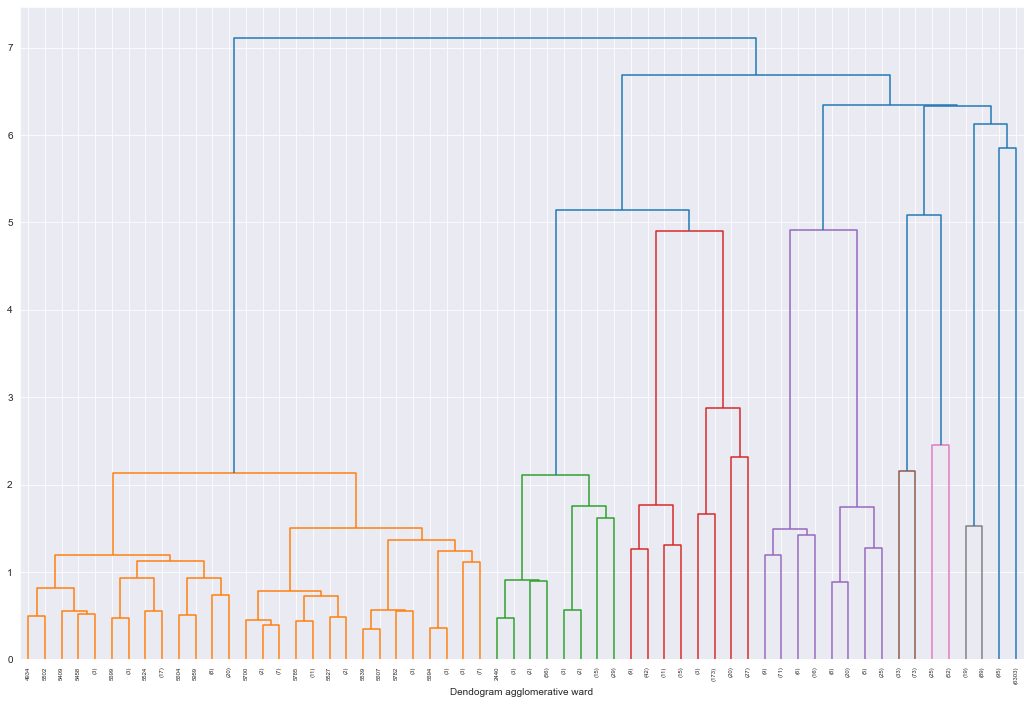

In [84]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model.fit(vec_matrix_tsvd)
plt.figure(figsize=(18, 12))
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel('Dendogram agglomerative ward')
plt.show()

# Agglomerative (complete)

In [85]:
clst_agg_avg = AgglomerativeClustering(n_clusters=10, linkage='complete')
clst_agg_avg.fit(vec_matrix_tsvd)

AgglomerativeClustering(linkage='complete', n_clusters=10)

In [86]:
data['label'] = clst_agg_avg.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  title_polarity  label  
0     ukraine angry zelensky vow punish russian atro...       -0.250000      6  
1                  war ukraine taking cover town attack        0.000000      8  
2                  ukraine war catastrophic global food        0.000000      6  
3     manchester arena bombing saffie roussoss paren...        0.000000      6  
4     ukraine conflict oil price soar highest level ...        0.000000      6  
...                                                 ...             ...    ...  
7359  premiership harlequin 2730 saracen sarries win...        0.183333      0  
7360                           queue expert helped plan        0.000000      6  
7361                          cowboy queen bonded horse        0.000000     

In [87]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

6    0.704916
4    0.065725
0    0.062738
8    0.046171
3    0.043590
1    0.022949
5    0.016567
2    0.015752
7    0.011135
9    0.010456
Name: label, dtype: float64

In [88]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0      punish  0.547101      6
1      global  0.709860      6
2       arena  0.614520      6
3     highest  0.577350      6
4       grant  0.568683      6
..        ...       ...    ...
77       year  0.918845      7
78     esteem  0.506666      7
79  childhood  0.597876      7
80    slavery  0.521664      7
81       epic  0.791599      7

[1566 rows x 3 columns]

In [90]:
viz_data.to_csv('./Data/title-agg-complete-clusters.csv', index=False)

In [84]:
visualize_clusters(viz_data)

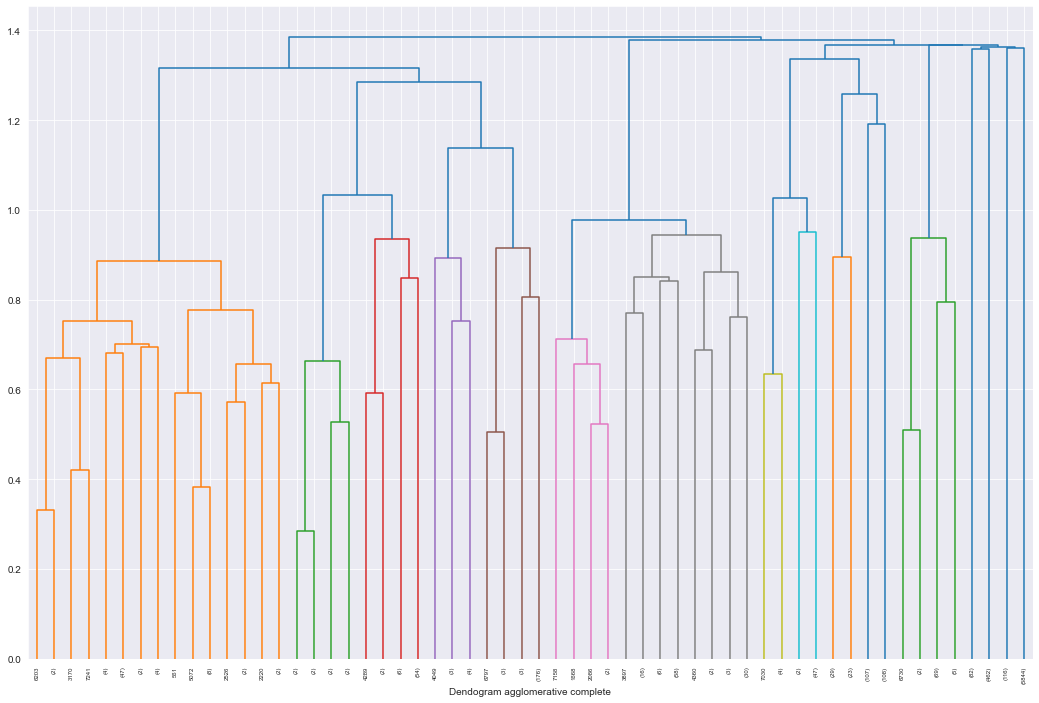

In [92]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')
model.fit(vec_matrix_tsvd)
plt.figure(figsize=(18, 12))
plot_dendrogram(model, truncate_mode='level', p=5)
plt.xlabel('Dendogram agglomerative complete')
plt.show()

# DBSCAN

In [98]:
dbscan = DBSCAN(eps=0.05)
dbscan.fit(vec_matrix_tsvd)

DBSCAN(eps=0.05)

In [99]:
data['label'] = dbscan.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  title_polarity  label  
0     ukraine angry zelensky vow punish russian atro...       -0.250000     -1  
1                  war ukraine taking cover town attack        0.000000     -1  
2                  ukraine war catastrophic global food        0.000000     -1  
3     manchester arena bombing saffie roussoss paren...        0.000000     -1  
4     ukraine conflict oil price soar highest level ...        0.000000     -1  
...                                                 ...             ...    ...  
7359  premiership harlequin 2730 saracen sarries win...        0.183333     -1  
7360                           queue expert helped plan        0.000000     -1  
7361                          cowboy queen bonded horse        0.000000     

In [100]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

-1    0.955866
 1    0.036122
 2    0.001494
 6    0.001222
 3    0.000951
 0    0.000815
 8    0.000815
 5    0.000679
 4    0.000679
 7    0.000679
 9    0.000679
Name: label, dtype: float64

In [101]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0           punish  0.547101     -1
1            cover  0.564675     -1
2           global  0.709860     -1
3            arena  0.614520     -1
4          highest  0.577350     -1
..             ...       ...    ...
0           iconic  0.689662      9
1   representative  0.686513      9
2        handshake  0.678691      9
3           corrie  0.672863      9
4            meant  0.703900      9

[459 rows x 3 columns]

In [102]:
viz_data.to_csv('./Data/title-dbscan-clusters.csv', index=False)

In [103]:
visualize_clusters(viz_data)

# OPTICS

In [104]:
optics = OPTICS(min_samples=25)
optics.fit(vec_matrix_tsvd)

OPTICS(min_samples=25)

In [105]:
data['label'] = optics.labels_
data

title  \
0     Ukraine: Angry Zelensky vows to punish Russian...   
1     War in Ukraine: Taking cover in a town under a...   
2            Ukraine war 'catastrophic for global food'   
3     Manchester Arena bombing: Saffie Roussos's par...   
4     Ukraine conflict: Oil price soars to highest l...   
...                                                 ...   
7359  Premiership: Harlequins 27-30 Saracens - Sarri...   
7360      The queue - and the expert who helped plan it   
7361    The cowboy and the Queen who bonded over horses   
7362   Queen amused by an American's breach of protocol   
7363  Queen Elizabeth II's special connection with W...   

                       pubDate  \
0    2022-03-07 08:01:56+00:00   
1    2022-03-06 22:49:58+00:00   
2    2022-03-07 00:14:42+00:00   
3    2022-03-07 00:05:40+00:00   
4    2022-03-07 08:15:53+00:00   
...                        ...   
7359 2022-09-17 18:07:42+00:00   
7360 2022-09-17 06:35:24+00:00   
7361 2022-09-16 23:01:06+00:00   
7362 2022-09-16 14:52:59+00:00   
7363 2022-09-17 06:38:22+00:00   

                                                   guid  \
0      https://www.bbc.co.uk/news/world-europe-60638042   
1      https://www.bbc.co.uk/news/world-europe-60641873   
2          https://www.bbc.co.uk/news/business-60623941   
3                https://www.bbc.co.uk/news/uk-60579079   
4          https://www.bbc.co.uk/news/business-60642786   
...                                                 ...   
7359   https://www.bbc.co.uk/sport/rugby-union/62927697   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                                   link  \
0     https://www.bbc.co.uk/news/world-europe-606380...   
1     https://www.bbc.co.uk/news/world-europe-606418...   
2     https://www.bbc.co.uk/news/business-60623941?a...   
3     https://www.bbc.co.uk/news/uk-60579079?at_medi...   
4     https://www.bbc.co.uk/news/business-60642786?a...   
...                                                 ...   
7359  https://www.bbc.co.uk/sport/rugby-union/629276...   
7360  https://www.bbc.co.uk/news/uk-england-cumbria-...   
7361  https://www.bbc.co.uk/news/world-us-canada-629...   
7362  https://www.bbc.co.uk/news/world-us-canada-629...   
7363  https://www.bbc.co.uk/news/uk-england-berkshir...   

                                            description  \
0     The Ukrainian president says the country will ...   
1     Jeremy Bowen was on the frontline in Irpin, as...   
2     One of the world's biggest fertiliser firms sa...   
3     The parents of the Manchester Arena bombing's ...   
4     Consumers are feeling the impact of higher ene...   
...                                                 ...   
7359  Saracens battle back from 17-0 down to beat Ha...   
7360  Thousands of people have lined up for miles to...   
7361  Sitting with the heads of state at Monday's fu...   
7362  When the monarch visited a US housing project ...   
7363  The Queen's association with Windsor Great Par...   

                                          title_cleaned  title_polarity  label  
0     ukraine angry zelensky vow punish russian atro...       -0.250000     -1  
1                  war ukraine taking cover town attack        0.000000     -1  
2                  ukraine war catastrophic global food        0.000000     -1  
3     manchester arena bombing saffie roussoss paren...        0.000000     -1  
4     ukraine conflict oil price soar highest level ...        0.000000     -1  
...                                                 ...             ...    ...  
7359  premiership harlequin 2730 saracen sarries win...        0.183333     -1  
7360                           queue expert helped plan        0.000000     -1  
7361                          cowboy queen bonded horse        0.000000     

In [106]:
assign_ratio = data['label'].value_counts() / data.shape[0]
assign_ratio

-1     0.911733
 1     0.016974
 5     0.007061
 2     0.006654
 10    0.005839
 8     0.005839
 4     0.005568
 9     0.005568
 7     0.004889
 11    0.004889
 0     0.004889
 3     0.004617
 14    0.004345
 12    0.003938
 6     0.003666
 13    0.003531
Name: label, dtype: float64

In [107]:
viz_data = to_viz_data(data, tfidf_data, data['label'].unique())
viz_data

word     tfidf  label
0          punish  0.547101     -1
1           cover  0.564675     -1
2          global  0.709860     -1
3           arena  0.614520     -1
4         highest  0.577350     -1
..            ...       ...    ...
36          tight  0.620684      9
37  investigation  0.636543      9
38          whats  0.680237      9
39       congress  0.659827      9
40       movement  0.655949      9

[850 rows x 3 columns]

In [110]:
viz_data.to_csv('./Data/title-optics-clusters.csv', index=False)

In [109]:
visualize_clusters(viz_data)